# 1. Initialization

## 1.1 Load packages

In [1]:
# Import modules for file I/O, data, visualization, math, and graph analysis

using DelimitedFiles      # For reading/writing delimited text files (like CSV, TSV)
using Plots               # For plotting and data visualization
using Colors              # For color utilities used in plots or visual outputs
using Random              # For random number generation
using Statistics          # For basic statistical functions (mean, std, etc.)
using LinearAlgebra       # For matrix operations and linear algebra routines
using Graphs              # For creating and analyzing graph structures
using JLD                 # For reading/writing .jld (Julia data) files
using GLM                 # For fitting generalized linear models (regression)
using DataFrames          # For tabular data manipulation
using DataStructures      # For additional data structures (e.g., heaps, queues, ordered dicts)
using Dates
using LaTeXStrings
# Include custom functions from an external file
include("common_functions.jl")

# Set default plotting style: boxed axes and automatic aspect ratio
default(framestyle = :box, aspect_ratio = :auto)

## 1.2 Load the Penrose tiling and make the associated graph objects

In [2]:
NUM_SUBDIVISIONS = 8 # Number of inflations for the Penrose tiling
# NUM_SUBDIVISIONS = 8 for the Penrose tiling used in the paper
# If running to understand the code, you can set this to 6 for faster execution

ngen = NUM_SUBDIVISIONS 
run_no = 1 # Identifier for the current run or simulation, useful for labeling outputs

# === Load tiling and graph structure ===

const ROT = exp(1im * 2 * pi/5)  
# Define a rotation constant: complex 72-degree rotation (used for pentagonal symmetries)

file_name = "./data/tiling_input/center_"  
# Base file path for data files

# --- Load the adjacency matrix for the graph ---
gph = open(readdlm, file_name * string(ngen) * "_graph.txt")  
graph = Array{Int}(undef, size(gph)[1], size(gph)[2])  
# Read in the graph connectivity as a matrix and convert all entries to Int
for i in 1:size(gph, 1)
    for j in 1:size(gph, 2)
        graph[i, j] = Int(gph[i, j])
    end
end

# --- Load coordinates of points making up the tiling ---
pts_x = vec(open(readdlm, file_name * string(ngen) * "_pts_re.txt"))  # x (real) components
pts_y = vec(open(readdlm, file_name * string(ngen) * "_pts_im.txt"))  # y (imaginary) components
pts = [complex(pts_x[i], pts_y[i]) for i in 1:length(pts_x)]  
# Combine x and y into complex numbers representing 2D points

# --- Load index mappings between different components ---
ind_A = round.(Int, vec(open(readdlm, file_name * string(ngen) * "_ind_A.txt")))  # Indices of A-sites
ind_B = round.(Int, vec(open(readdlm, file_name * string(ngen) * "_ind_B.txt")))  # Indices of B-sites

AtoG = round.(Int, vec(open(readdlm, file_name * string(ngen) * "_AtoG.txt")))  # Mapping from A-site index to graph index
BtoG = round.(Int, vec(open(readdlm, file_name * string(ngen) * "_BtoG.txt")))  # Mapping from B-site index to graph index

# --- Load matching and plaquette information ---
max_match = round.(Int, open(readdlm, file_name * string(ngen) * "_max_match.txt"))  # Maximum matching edges
plaq = round.(Int, open(readdlm, file_name * string(ngen) * "_plaq.txt"))            # Plaquette index data

plaq_spins = round.(Int, open(readdlm, file_name * string(ngen) * "_plaq_spins.txt"))  
# Each row encodes four spins making up a plaquette
# Format: [s1, s2, s3, s4], with adjacent spins sharing vertices in a cyclic order:
# s1—s2—s4—s3—s1

# --- Load spin-edge connectivity and monomer data ---
ABedge_no = round.(Int, open(readdlm, file_name * string(ngen) * "_ABedge_no.txt"))  
# Edge numbers between A and B sublattices

spins_to_edges = round.(Int, open(readdlm, file_name * string(ngen) * "_spins_to_edges.txt"))  
# Maps each spin to an edge index

monomer_A = vec(round.(Int, open(readdlm, file_name * string(ngen) * "_monomer_A.txt")))  
# Monomer positions on A sublattice

monomer_B = vec(round.(Int, open(readdlm, file_name * string(ngen) * "_monomer_B.txt")))  
# Monomer positions on B sublattice

# --- Constants derived from the loaded data ---
const nspins = size(spins_to_edges, 1)  # Total number of spins
const npts = size(graph, 1)             # Number of graph nodes (points)
const nplaqs = length(plaq_spins[:,1])  # Number of plaquettes
const ymax = maximum(pts_y)            # Maximum y-coordinate (used for plotting/scaling)

46.9787137637

In [3]:
# === Build neighbor list from adjacency matrix ===

nbrG = []  # Initialize list to store neighbors for each point

for i in 1:npts
    nnn = []  # Temporary list for neighbors of point i
    for j in 1:npts
        if graph[i, j] == 1  # Check if there is an edge between node i and j
            push!(nnn, j)    # Add j to i's list of neighbors
        end
    end
    push!(nbrG, nnn)  # Store neighbor list for point i
end

nbrG = convert_to_int(nbrG)  # Convert neighbor list elements to integers (if not already)

# === Build edge index map between graph nodes using ABedge_no ===

Gedge_no = fill(0, npts, npts)  # Initialize a matrix to store edge numbers between points

for i in 1:npts
    for j in 1:npts
        if graph[i, j] == 1  # Check if i and j are connected
            if ind_A[i] < npts + 5
                # Use ABedge_no with A-site index at i and B-site index at j
                Gedge_no[i, j] = ABedge_no[ind_A[i], ind_B[j]]
            elseif ind_B[i] < npts + 5
                # Use ABedge_no with B-site index at i and A-site index at j (reverse roles)
                Gedge_no[i, j] = ABedge_no[ind_A[j], ind_B[i]]
            else
                println("Error!")  # Handle case where neither condition is satisfied
            end
        end
    end
end

# === Generate spin positions and initialize spin configuration ===

spins_pos = generate_spins_pos()       # Compute physical positions of spins, likely for plotting
config = reset_config(max_match);       # Initialize or reset spin configuration using maximum matching

In [4]:
# === Generate Graph objects representing different physical structures ===

# Create a graph for the Penrose tiling (or similar lattice structure)
# - Nodes are given by 'pts'
# - Edges by the adjacency matrix 'graph'
# - npts: number of points
# - plaq: list of plaquettes
# - nplaqs: number of plaquettes
penrose = Graph(pts, graph, npts, plaq, nplaqs)

# Create a graph representing the spin degrees of freedom
# - Nodes at positions 'spins_pos'
# - Edges defined from adjacency of plaquette spins
# - nspins: total number of spins
# - plaq_spins: spin groupings per plaquette
spins = Graph(spins_pos, generate_spins_adj(plaq_spins, nspins), nspins, plaq_spins, nplaqs)

# Create a graph based on the maximum matching configuration
# - Edges are generated from 'max_match' using geometry of 'penrose'
# - Plaquette info is unused here (set to filler)
dcov = Graph(pts, generate_max_match_adj(max_match, penrose), npts, fill(0, 1, 1), 0)

Graph(ComplexF64[35.6708752289 + 4.7360679775im, 34.7198187126 + 5.0450849719im, 35.0830899766 + 5.5450849719im, 34.1320334604 + 4.2360679775im, 34.1320334604 + 5.8541019662im, 34.1320334604 + 6.8541019662im, 36.6219317452 + 5.0450849719im, 36.6219317452 + 6.0450849719im, 37.2097169975 + 5.8541019662im, 38.1607735138 + 5.5450849719im  …  21.0947567836 - 15.3262379212im, 20.5069715314 - 16.1352549156im, 21.0947567836 - 16.3262379212im, 22.0458132999 - 15.0172209269im, 21.6825420359 - 16.1352549156im, 19.5559150151 - 14.2082039325im, 18.6048584988 - 13.5172209269im, 20.5069715314 - 14.5172209269im, 21.0947567836 - 14.3262379212im, 20.1437002674 - 15.0172209269im], [0 0 … 0 0; 0 0 … 0 0; … ; 0 0 … 0 0; 0 0 … 0 0], 8111, [0;;], 0)

## 1.3 Visualize the tiling and the initial dimer covering

In [5]:
# # === Plotting the configuration: Turned off since it takes time to plot ===

# p = plot_generate(1000)  
# # Initialize a plot canvas with size parameter 500 (likely sets resolution or canvas dimensions)

# p = plot_edges(p, penrose)  
# # Draw the edges of the Penrose tiling (or general lattice) on the plot

# p = plot_config(p, config)  
# # Overlay the current configuration (e.g., dimers, spins, monomers) onto the plot

# display(p)  
# # Render and display the final plot

# ;  

# 2. Monte Carlo | Full lattice

Perfrom Monte Carlo on the full lattice and calculate average dimer occupation of each edge. Use this information to determine the monomer membranes (edges which are never occupied). After the membranes are identified, we will separate the full graph into smaller connected pieces and perform Monte Carlo on individual pieces.

In [6]:
# === Function to calculate the total Sz (proportional to the dimer density) at each edge ===
function sz_correlator(config::Vector{Int64}, running_sum::Vector{Int64}, spin_origin::Int64)
    if config[spin_origin] == 1
        # If the origin spin is up (+1), there is a dimer on that edge of the Penrose tiling 
        # add the configuration vector to the running sum
        for i in eachindex(running_sum)
            running_sum[i] = running_sum[i] + config[i]
        end
    else
        # If the origin spin is down (-1), there is no dimer on that edge of the Penrose tiling 
        # subtract the configuration vector from the running sum
        for i in eachindex(running_sum)
            running_sum[i] = running_sum[i] - config[i]
        end
    end
end

# === Function to add one vector to another in-place ===
# Defining a separate function so that it is fast
function add_vec!(vec1::Vector{Int64}, vec2::Vector{Int64})
    for i in eachindex(vec1)
        vec1[i] = vec1[i] + vec2[i]
    end
end


add_vec! (generic function with 1 method)

In [7]:
# === Attempt a monomer move in the dimer configuration ===
function monomer_move(config::Vector{Int64}, npts::Int64, Gedge_no::Matrix{Int64}, nbrG::Vector{Vector{Int64}})
    initial_site::Int64 = rand(1:npts)  # Randomly select a site
    nbr_initial::Vector{Int64} = nbrG[initial_site]  # Get its neighbors

    # Check if the initial random site is not part of a dimer (i.e., it's a monomer)
    for i in nbr_initial
        if config[Gedge_no[initial_site, i]] == 1 # An dimer exists on the edge connecting initial_site and i
            return false  # Site is part of a dimer; not a monomer
        end
    end

    # Site is a monomer — attempt to move it
    special_nbr::Int64 = rand(nbr_initial)  # Choose a random neighbor to move toward
    nnbr::Vector{Int64} = nbrG[special_nbr]  # Get neighbors of that neighbor

    for i in nnbr
        if config[Gedge_no[i, special_nbr]] == 1  # Look for a dimer adjacent to the neighbor
            config[Gedge_no[i, special_nbr]] = -1  # Remove old dimer
            config[Gedge_no[initial_site, special_nbr]] = 1  # Add new dimer linking initial monomer site
            return true  # Move successful
        end
    end
    return false  # No valid move found
end

# === Attempt a plaquette flip move (resonance/ring exchange) in the configuration ===
function plaq_move(config::Vector{Int64}, nplaqs::Int64, plaq_spins::Matrix{Int64})
    random_plaq = rand(1:nplaqs)  # Randomly select a plaquette

    # Extract the four spins (edges) forming the plaquette
    s1 = plaq_spins[random_plaq, 1]
    s2 = plaq_spins[random_plaq, 2]
    s3 = plaq_spins[random_plaq, 3]
    s4 = plaq_spins[random_plaq, 4]

    # Flippable configuration 1: if dimers occupy s1 and s4, flip to s2 and s3
    if config[s1] == 1 && config[s4] == 1
        config[s1] = -1
        config[s4] = -1
        config[s2] = 1
        config[s3] = 1
        return true  # Flip successful

    # Flippable configuration 2: if dimers occupy s2 and s3, flip to s1 and s4
    elseif config[s2] == 1 && config[s3] == 1
        config[s2] = -1
        config[s3] = -1
        config[s1] = 1
        config[s4] = 1
        return true  # Flip successful
    end

    return false  # No valid plaquette flip
end

plaq_move (generic function with 1 method)

In [8]:
# === Main Monte Carlo code to measure ⟨Sz⟩ and Sz-Sz correlators without averaging over origins ===
function mc_mobile_full_no_avg(mc_steps::Int64, Nmix::Int64, config::Vector{Int64},
                               plaq_spins::Matrix{Int64}, spin_origin::Int64,
                               Gedge_no::Matrix{Int64}, nbrG::Vector{Vector{Int64}})
    
    nplaqs::Int64 = size(plaq_spins, 1)     # Number of plaquettes
    nspins::Int64 = length(config)          # Total number of spins

    sz_corr_array::Vector{Int64} = fill(0, nspins)  # Accumulator for Sz-Sz correlator from spin_origin
    sz_avg::Vector{Int64} = fill(0, nspins)         # Accumulator for average ⟨Sz⟩ across configurations

    # === Main Monte Carlo sampling loop ===
    for i in 1:mc_steps
        # Perform Nmix rounds of local updates before measurements
        for j in 1:Nmix
            while !monomer_move(config, npts, Gedge_no, nbrG)
                # Attempt monomer move until successful
            end
            while !plaq_move(config, nplaqs, plaq_spins)
                # Attempt plaquette flip until successful
            end
        end

        # Accumulate ⟨Sz⟩ and Sz-Sz correlator measurements
        add_vec!(sz_avg, config)
        sz_correlator(config, sz_corr_array, spin_origin)
    end

    # Normalize by number of Monte Carlo steps
    sz_corr_array_float = sz_corr_array / mc_steps
    sz_avg_float = sz_avg / mc_steps

    return sz_avg_float, sz_corr_array_float  # Return ⟨Sz⟩ and ⟨Sz_origin Sz_i⟩
end

mc_mobile_full_no_avg (generic function with 1 method)

In [9]:
# === Set Monte Carlo parameters and run the simulation ===

mc_steps = 20_000  # Total number of Monte Carlo steps (e.g., 20,000)
Nmix = 100                # Number of update steps between measurements (thermalization/mixing)
spin_origin = 300         # Index of the spin used as the correlation reference point

config = reset_config(max_match)  
# Initialize the spin configuration using the maximum matching (dimer configuration)

# Run the Monte Carlo loop and measure observables
@time sz_disg, szsz_disg = mc_mobile_full_no_avg(
    mc_steps,              # Number of MC steps
    Nmix,                  # Number of mixing steps per measurement
    config,                # Initial spin/dimer configuration
    plaq_spins,            # Plaquette spin structure
    spin_origin,           # Spin origin for Sz-Sz correlator
    Gedge_no,              # Mapping from graph edges to spin indices
    convert_to_int(nbrG)   # Neighbor list with integer values
)
;

  1.257596 seconds (16.43 k allocations: 1.645 MiB, 0.30% compilation time)


In [10]:
# # === Visualize the monomer membranes using Sz expectation values ===
# # Turned off since it takes time to plot


# p = plot_generate(1200)  
# # Initialize the plotting canvas with size parameter 500

# p = plot_edges(p, penrose)  
# # Draw the lattice (e.g., Penrose tiling) edges as a background

# p = plot_sz(p, spins, log.(abs.(sz_disg .+ 1.0 .+ 1e-5)))  
# # Plot the spin expectation values ⟨Sz⟩
# # Apply log scale for better contrast and numerical stability:
# # - Shift by +1.0 to center values
# # - Add small 1e-5 to avoid log(0)

# plot!(colorbar = true)  
# # Add a colorbar to the plot

# display(p) ;

# 3. Generate disconnected graph

In [11]:
# === Identify monomer membrane edges from Sz data ===
function get_monomer_membranes_numerics(sz)
    membrane_edges = []

    for i in 1:nspins
        if abs(sz[i] + 1.0) < 1e-3
            # Spin is strongly polarized at Sz ≈ -1, indicating part of a membrane
            a, b = spins_to_edges[i, :]         # Get A/B spin indices connected by this edge
            push!(membrane_edges, [AtoG[a], BtoG[b]])  # Convert to graph vertex indices and store
        end
    end

    return convert_to_int(membrane_edges)  # Ensure indices are integers
end

# === Create a new graph with membrane edges removed ===
function generate_disconnected_graph(sz)
    # Create a deep copy of the original Penrose graph
    disg = Graph(copy(pts), copy(graph), copy(npts), copy(plaq), copy(nplaqs))

    # Identify edges that correspond to monomer membranes
    monomer_membrane = get_monomer_membranes_numerics(sz)

    # Remove these edges from the adjacency matrix
    for i in monomer_membrane
        p1, p2 = i
        disg.adj[p1, p2] = 0
        disg.adj[p2, p1] = 0
    end

    return disg  # Return the disconnected graph
end

generate_disconnected_graph (generic function with 1 method)

In [12]:
monomer_membrane = get_monomer_membranes_numerics(sz_disg);
# === Analyze connectivity after removing monomer membranes ===

disg = generate_disconnected_graph(sz_disg)  
# Generate a new graph where membrane edges (Sz ≈ -1) have been removed

g = SimpleGraph(disg.adj)  
# Convert the (symmetric) adjacency matrix to a SimpleGraph object from Graphs.jl

ccg = connected_components(g)  
# Compute the list of connected components in the modified graph

;  # Suppress output

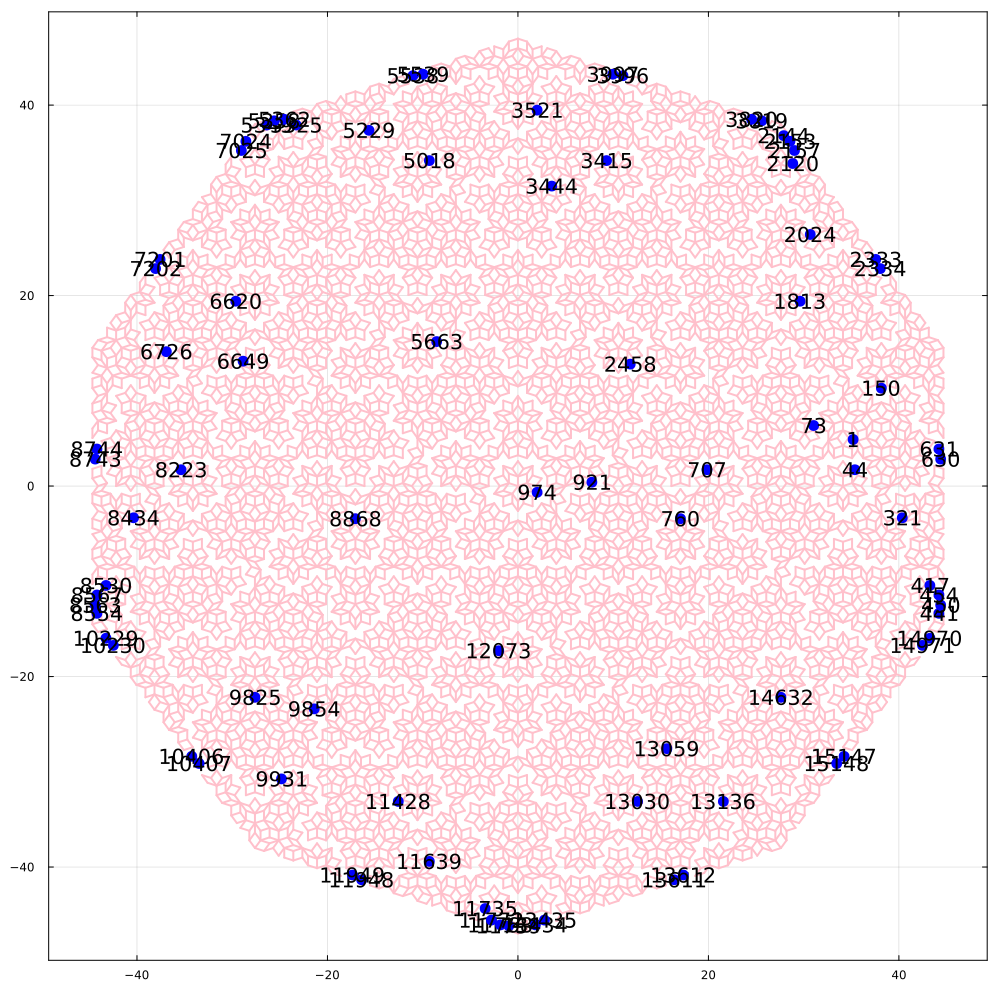

In [13]:
# === Visualize connected components after membrane disconnection ===

disg = generate_disconnected_graph(sz_disg)  
# Create a graph with monomer membrane edges removed (based on Sz ≈ -1)

p = plot_generate(1000)  
# Initialize plot canvas at higher resolution (e.g., 1000 units)

p = plot_edges(p, disg)  
# Draw the edges of the disconnected graph

# Optional: Uncomment to overlay all spin sites
# p = plot_sites(p, spins, :blue, 0; annotate = false, markersize=2)

# For each connected component, find and annotate one representative spin position
for i in 1:length(ccg)
    j = -1
    # Find a neighbor of the first node in the component to identify an edge
    for k in 1:disg.n
        if disg.adj[ccg[i][1], k] == 1
            j = k
            break
        end
    end

    spin_number = Gedge_no[ccg[i][1], j]  # Map edge to spin index
    point = spins_pos[spin_number]       # Get 2D position of that spin

    # Mark the spin's location on the plot
    scatter!(p,
        [real(point)], [imag(point)],
        mc = :blue,                      # Marker color
        markerstrokewidth = 0,          # No border
        series_annotations = string(spin_number),  # Optional label
        label = "",                     # Do not show in legend
        markersize = 6
    )
end

display(p)  # Show the plot
;

## 3.1 Set spin origin to select a connected piece

In [14]:
# === SETTING SPIN ORIGIN FOR CORRELATION MEASUREMENT ===
# ###########################################################################################################

# Spin origins for different generations:

# Different regions for ngen=8: 921, 707, 1
# Different regions for ngen=7: 390, 292, 1

# Set the spin origin index here:
spin_origin = 707  # Current setting: Region R2 for ngen = 8

region = ""
if ngen == 8
    if spin_origin == 1
        region = "R2"  # Region R2 corresponds to spin_origin = 1
    elseif spin_origin == 707
        region = "R3"  # Region R3 corresponds to spin_origin = 707
    else   
        println("Error: Invalid spin origin index for ngen=8!")
    end
    ### Note that this convention of naming regions is DIFFERENT from the one used in the paper.
    # R2 in code corresponds to R1 in the paper, and R3 in code corresponds to R2 in the paper.

    # Notes for paper figures:
    # - Region R2 (paper’s R1): spin_origin = 1
    # - Region R3 (paper’s R2): spin_origin = 707
end
@show region
# ###########################################################################################################

region = "R3"


"R3"

## 3.2 Generate subgraph

In [15]:
# === Identify the sublattice connected to the selected spin_origin ===

sub_lat = 0  # Will hold indices of sublattice vertices

# Get endpoints of the spin (edge) corresponding to the spin_origin
a, b = spins_to_edges[spin_origin, :]
p1 = AtoG[a]  # Convert to graph vertex index
p2 = BtoG[b]

# Find the connected component that contains both endpoints
for i in 1:length(ccg)
    if p1 in ccg[i] && p2 in ccg[i]
        sub_lat = ccg[i]
        break
    end
end

# Log size and indices of the sublattice
println(length(sub_lat))
println(sub_lat)

# === Initialize sublattice point list and lookup mapping ===

sub_npts = length(sub_lat)
sub_pts = [pts[sub_lat[i]] for i in 1:sub_npts]  # Coordinates of sublattice points

lat_to_sublat = fill(0, npts)  # Map full lattice indices to sublattice indices
for i in 1:sub_npts
    lat_to_sublat[sub_lat[i]] = i
end

# === Build sublattice edge and spin graph ===

sub_spins = Int64[]  # Store spin indices associated with edges in the subgraph
sub_graph = fill(0, (sub_npts, sub_npts))  # Adjacency matrix of the subgraph

sub_spins_to_full_spins = fill(0, nspins)  # Map full spin index to sub spin index
sub_spins_lat_mat = fill(0, sub_npts, sub_npts)  # Map between subgraph vertices and spin index

# Extract all edges (spins) within the subgraph
for i in 1:sub_npts-1
    for j in i+1:sub_npts
        if graph[sub_lat[i], sub_lat[j]] == 1
            sub_graph[i,j] = 1
            sub_graph[j,i] = 1
            push!(sub_spins, Gedge_no[sub_lat[i], sub_lat[j]])
            sub_spins_to_full_spins[Gedge_no[sub_lat[i], sub_lat[j]]] = length(sub_spins)
            sub_spins_lat_mat[i,j] = length(sub_spins)
            sub_spins_lat_mat[j,i] = length(sub_spins)
        end
    end
end

# === Generate spin positions for the subgraph ===

sub_spins_to_edges = fill(0, 2, length(sub_spins))  # Maps each sub spin to its vertex pair
count = 1
for i in 1:sub_npts-1
    for j in i+1:sub_npts
        if graph[sub_lat[i], sub_lat[j]] == 1
            sub_spins_to_edges[1, count] = i
            sub_spins_to_edges[2, count] = j
            count += 1
        end
    end
end

sub_spins_pos = ComplexF64[]  # 2D position of sub spins
for i in 1:length(sub_spins)
    push!(sub_spins_pos, spins_pos[sub_spins[i]])
end

# === Extract plaquettes composed entirely of sub spins ===

sub_plaq = []
for i in 1:size(plaq_spins, 1)
    s1, s2, s3, s4 = plaq_spins[i, :]
    if s1 in sub_spins && s2 in sub_spins && s3 in sub_spins && s4 in sub_spins
        push!(sub_plaq, [sub_spins_to_full_spins[s1], sub_spins_to_full_spins[s2], 
                         sub_spins_to_full_spins[s3], sub_spins_to_full_spins[s4]])
    end
end

# Convert list of plaquettes to matrix form
sub_plaq_temp = fill(0, length(sub_plaq), 4)
for i in 1:length(sub_plaq)
    for j in 1:4
        sub_plaq_temp[i,j] = sub_plaq[i][j]
    end
end
sub_plaq = sub_plaq_temp

# === Create adjacency matrix for spins based on shared plaquettes ===

sub_nspins = length(sub_spins)
sub_nplaq = size(sub_plaq, 1)
sub_spins_graph2 = fill(0, sub_nspins, sub_nspins)

for i in 1:sub_nplaq
    s1, s2, s3, s4 = sub_plaq[i, :]
    sub_spins_graph2[s1, s3] = 1
    sub_spins_graph2[s1, s2] = 1
    sub_spins_graph2[s3, s4] = 1
    sub_spins_graph2[s4, s2] = 1
    sub_spins_graph2[s3, s1] = 1
    sub_spins_graph2[s2, s1] = 1
    sub_spins_graph2[s4, s3] = 1
    sub_spins_graph2[s2, s4] = 1
end

# === Construct spin-spin adjacency matrix based on full graph structure ===

sub_spins_graph = fill(0, sub_nspins, sub_nspins)
for i in 1:nspins
    if sub_spins_to_full_spins[i] > 0
        for j in 1:nspins
            if spins.adj[i,j] == 1 && sub_spins_to_full_spins[j] > 0
                s_i = sub_spins_to_full_spins[i]
                s_j = sub_spins_to_full_spins[j]
                sub_spins_graph[s_i, s_j] = 1
                sub_spins_graph[s_j, s_i] = 1
            end
        end
    end
end

# === Construct subgraph objects ===

sub_penrose = Graph(sub_pts, sub_graph, sub_npts, fill(0,1,1), size(sub_plaq, 1))
sub_penrose_spin = Graph(sub_spins_pos, sub_spins_graph, length(sub_spins_pos), sub_plaq, size(sub_plaq, 1))

# === Generate spin neighbor lists for each vertex in the subgraph ===

sub_lat_nbr_spin = []
sub_penrose_nbr = get_sub_neighbors(sub_penrose)
for i in 1:sub_penrose.n
    temp = []
    for neighbor in sub_penrose_nbr[i]
        append!(temp, sub_spins_lat_mat[i, neighbor])
    end
    push!(sub_lat_nbr_spin, temp)
end

sub_lat_nbr_spin = convert_to_int(sub_lat_nbr_spin)
;

1300
[340, 341, 344, 345, 346, 347, 357, 360, 361, 367, 368, 370, 371, 372, 373, 374, 375, 376, 377, 396, 397, 400, 401, 402, 424, 428, 431, 432, 437, 438, 439, 440, 441, 442, 443, 444, 445, 455, 458, 468, 469, 472, 473, 474, 475, 484, 487, 488, 493, 494, 496, 497, 498, 499, 500, 501, 502, 503, 504, 505, 506, 507, 508, 509, 510, 511, 512, 514, 515, 516, 517, 518, 519, 520, 521, 522, 523, 524, 527, 531, 532, 533, 534, 535, 536, 538, 540, 541, 545, 548, 549, 550, 551, 552, 553, 554, 630, 631, 634, 635, 636, 637, 647, 650, 651, 656, 657, 659, 660, 661, 662, 663, 664, 665, 666, 685, 686, 689, 690, 691, 713, 798, 799, 801, 802, 803, 810, 813, 814, 815, 816, 817, 818, 819, 829, 832, 833, 849, 1176, 1177, 1180, 1181, 1182, 1183, 1192, 1195, 1196, 1202, 1203, 1205, 1206, 1207, 1208, 1209, 1210, 1211, 1212, 1225, 1226, 1229, 1230, 1231, 1250, 1254, 1257, 1258, 1262, 1263, 1264, 1265, 1266, 1267, 1268, 1269, 1270, 1275, 1278, 1287, 1288, 1290, 1291, 1292, 1293, 1300, 1302, 1303, 1307, 1308, 1309

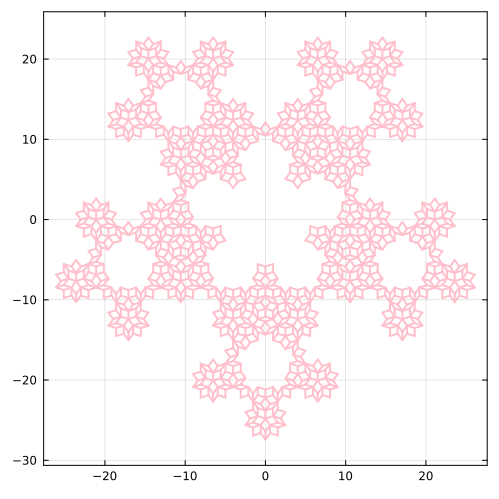

In [16]:
# === Plot the extracted sub-Penrose lattice ===

p = plot_generate(500)             # Initialize the plot with resolution 500
p = plot_edges(p, sub_penrose)     # Draw the edges of the subgraph onto the plot

# 4. Start analysis

## 4.1 General functions


In [17]:
"""
    smart_mean(arr::Vector{<:Vector})

Compute the element-wise mean across a collection of vectors `arr`, 
handling variable-length inputs by averaging only available entries at each index.
"""
function smart_mean(arr)
    temp = []
    n = length(arr)

    # Loop over max possible length
    for i in 1:maximum(length.(arr))
        values_at_i = []
        for j in 1:n
            if i <= length(arr[j])
                push!(values_at_i, arr[j][i])
            end
        end
        if !isempty(values_at_i)
            push!(temp, mean(values_at_i))
        end
    end
    return temp
end

"""
    smart_std_err(arr::Vector{<:Vector})

Compute the element-wise standard error across a collection of vectors `arr`,
handling variable-length inputs and using Bessel's correction.
"""
function smart_std_err(arr)
    temp = []
    n = length(arr)

    # Loop over max possible length
    for i in 1:maximum(length.(arr))
        values_at_i = []
        for j in 1:n
            if i <= length(arr[j])
                push!(values_at_i, arr[j][i])
            end
        end
        if length(values_at_i) > 1
            # Use sample standard deviation divided by sqrt(N-1)
            push!(temp, std(values_at_i) / sqrt(length(values_at_i) - 1))
        elseif length(values_at_i) == 1
            push!(temp, 0.0)  # conservative estimate: no variance
        end
    end
    return temp
end

smart_std_err

# 5. Spin-spin correlator

In [ ]:
"""
    post_process_sz_partial(szsz::Matrix{Float64}, sz::Vector{Float64}, 
                            sub_spins_pos::Vector{ComplexF64}; 
                            averaging_radius=0.4, fraction=1.0)

Extracts the connected spin–spin correlations and corresponding distances 
from a subset of spins located at complex positions.

Returns:
- `distance`: Euclidean distance between all distinct spin pairs (i < j)
- `szsz_conn`: Corresponding connected correlation ⟨SᶻᵢSᶻⱼ⟩ - ⟨Sᶻᵢ⟩⟨Sᶻⱼ⟩
"""
function post_process_sz_partial(szsz::Matrix{Float64}, sz::Vector{Float64}, 
                                 sub_spins_pos::Vector{ComplexF64}; 
                                 averaging_radius=0.4, fraction=1.0)

    distance = Float64[]
    szsz_conn = Float64[]
    sub_nspins = length(sub_spins_pos)

    for i in 1:sub_nspins-1
        for j in i+1:sub_nspins
            # Euclidean distance between spins i and j
            dist_ij = abs(sub_spins_pos[i] - sub_spins_pos[j])

            # Connected correlation function: ⟨SᶻᵢSᶻⱼ⟩ - ⟨Sᶻᵢ⟩⟨Sᶻⱼ⟩
            conn_ij = abs(szsz[i, j] - sz[i] * sz[j])

            push!(distance, dist_ij)
            push!(szsz_conn, conn_ij)
        end
    end

    return distance, szsz_conn
end

### 5.1 Load data

In [ ]:
nfile = 2  # Number of MC result files
# There are 20 files in total, but we use only the first 2 for testing

# Select filenames based on the region
if region == "R2"
    filename = ["./data/R2_mc/new_run_R2_" * string(i) * ".jld" for i in 1:nfile]
elseif region == "R3"
    filename = ["./data/R3_mc/new_run_R3_" * string(i) * ".jld" for i in 1:nfile]
end

# Initialize storage lists and accumulators
sz_list = []
szsz_list = []
szsz_error = []
master_dist = []
master_szsz = []
corr_list = []

nspins = sub_penrose_spin.n
corr_mean = zeros(nspins, nspins)
corr_sq = zeros(nspins, nspins)
szsz_mean = zeros(nspins, nspins)
sz_mean = zeros(nspins)
szsz_sq = zeros(nspins, nspins)
sz_sq = zeros(nspins)

# Loop over all files and accumulate statistics
for f in filename
    loaded_data = load(f)
    dat1, dat2 = loaded_data["data_to_save"]
    sz1, szsz1, vison1, vfm_arr, mfm_arr = dat1

    # Compute connected correlator matrix ⟨Sz_i Sz_j⟩ - ⟨Sz_i⟩⟨Sz_j⟩
    corr = zeros(nspins, nspins)
    for i in 1:nspins-1
        for j in i+1:nspins
            val = szsz1[i, j] - sz1[i] * sz1[j]
            corr[i, j] = val
            corr[j, i] = val
        end
    end
    push!(corr_list, corr)

    # Accumulate raw statistics for mean and error estimation
    szsz_mean .+= szsz1
    sz_mean .+= sz1
    szsz_sq .+= szsz1 .^ 2
    sz_sq .+= sz1 .^ 2
end

# Normalize accumulated sums
szsz_mean ./= nfile
sz_mean ./= nfile
;

In [ ]:
# Stack correlation matrices into a 3D array of shape (nspins, nspins, nfile)
corr_array = reduce(hcat, [reshape(c, :, 1) for c in corr_list])
corr_array = reshape(corr_array, size(corr_list[1])..., length(corr_list))  # (n, n, nfile)

# Mean and standard error computed elementwise across runs
corr_mean = mean(corr_array, dims=3)[:, :, 1]  # remove singleton dim
corr_std_err = std(corr_array, dims=3)[:, :, 1] ./ sqrt(nfile - 1)
;

In [ ]:
function post_process_sz_binner2(corr, corr_std_err, sub_spins_pos, averaging_radius=0.2, fraction=1.0)
    # Initialize flat lists for distances, correlators, and errors
    distance, szsz_conn, err_list = [], [], []
    sub_nspins = length(sub_spins_pos)

    # Flatten upper triangle of correlation matrix
    for i in 1:sub_nspins-1
        for j in i+1:sub_nspins
            push!(distance, abs(sub_spins_pos[i] - sub_spins_pos[j]))
            push!(szsz_conn, corr[i,j])
            push!(err_list, corr_std_err[i,j])
        end
    end

    # Setup bins based on averaging radius
    xrange = 20.0
    nbins = Int(xrange / averaging_radius)
    bins = [[] for _ in 1:nbins]
    err_bins = [[] for _ in 1:nbins]

    # Assign data to bins
    for i in 1:length(distance)
        if distance[i] < xrange
            binno = Int(ceil(distance[i] / averaging_radius))
            push!(bins[binno], szsz_conn[i])
            push!(err_bins[binno], err_list[i])
        end
    end

    # Initialize outputs
    avg_d, avg_cs, avg_err = [], [], []
    env_up, env_dn, log_dev = [], [], []

    # Process each bin
    for i in 1:length(bins)
        if !isempty(bins[i])
            b = bins[i]
            err_b = err_bins[i]

            # Mean correlator and distance
            push!(avg_cs, abs(mean(b)))
            push!(avg_err, mean(err_b))
            push!(avg_d, averaging_radius * (i - 0.5))

            # Log10 standard deviation
            push!(log_dev, std(log10.(abs.(b))))

            # Fractional envelope (e.g., 80% central range if fraction = 0.8)
            # In the paper, we use fraction = 1.0
            sorted_vals = sort(abs.(b))
            ndat = length(sorted_vals)
            bot = Int(round((1 - fraction) / 2 * ndat))
            top = Int(round((1 - (1 - fraction) / 2) * ndat))
            interval = sorted_vals[bot+1:top]

            push!(env_up, maximum(interval))
            push!(env_dn, minimum(interval))
        end
    end

    return avg_d, avg_cs, avg_err, env_up, env_dn, log_dev, bins
end

In [ ]:
# --- Parameters ---
averaging_radius = 0.4  # Bin width for distance averaging

# --- Bin and process correlation data ---
clean_dist, clean_szsz_conn, clean_err, env_up, env_dn, log_dev, bins = 
    post_process_sz_binner2(corr_mean, corr_std_err, sub_spins_pos, averaging_radius, 1.0)

# --- Sort data by increasing distance ---
perm = sortperm(clean_dist)
clean_dist = clean_dist[perm]
clean_szsz_conn = clean_szsz_conn[perm]
clean_err = clean_err[perm]
env_up = env_up[perm]
env_dn = env_dn[perm]

# --- Plot log-scale correlation vs. distance ---
scatter(clean_dist, clean_szsz_conn; yaxis = :log, xlim = (0, 9), label = "⟨SᶻSᶻ⟩ - ⟨Sᶻ⟩²", xlabel = "Distance", ylabel = "Connected correlator", legend = :topright)

### 5.2 Save processed sz-sz correlator

In [ ]:
# Prepare data to be saved
szsz_plot_data = [
    clean_dist,          # Average binned distances
    clean_szsz_conn,     # Average connected correlators
    env_dn,              # Lower envelope of binned data
    env_up,              # Upper envelope of binned data
    clean_err,           # Standard error in each bin
    averaging_radius,    # Bin width
    log_dev,             # Standard deviation of log-correlator values
    bins                 # Raw data points in each bin
]

# Determine save path based on region
flname = ""
if region == "R2"
    flname = "./data/plot_data/R2_szsz.jld"
elseif region == "R3"
    flname = "./data/plot_data/R3_szsz.jld"
end

# Save the data
save(flname, "szsz_plot_data", szsz_plot_data)

# --- To reload later ---
# clean_dist, clean_szsz_conn, env_dn, env_up, clean_err, averaging_radius, log_dev, bins = 
#     load(flname)["szsz_plot_data"]

### 5.3 Preliminary plot of the data

In [ ]:
# Load previously saved plot data if needed
# clean_dist, clean_szsz_conn, env_dn, env_up, clean_err, averaging_radius = load("./data/plot_data/R3_szzs_pm.jld")["szsz_plot_data"]

# --- Plot settings ---
fntsize = 11
p = plot(
    xlim = (0, 9),
    ylim = (1e-6, 1),
    yaxis = :log,
    xformatter = :latex,
    yformatter = :latex,
    framestyle = :box,
    size = 1.2 .* (350, 180),
    legendfontsize = 9,
    xtickfontsize = fntsize,
    ytickfontsize = fntsize,
    xguidefontsize = fntsize,
    yguidefontsize = fntsize
)

# --- Add shaded envelope between upper and lower bounds ---
p = plot!(
    clean_dist, clean_szsz_conn,
    ribbon = (clean_szsz_conn - env_dn, env_up - clean_szsz_conn),
    linewidth = 0.0,
    label = false
)

# --- Add error bars on data points ---
p = scatter!(
    clean_dist, clean_szsz_conn,
    yerr = clean_err,
    label = L"\textrm{Data}",
    markercolor = :black
)

# --- Custom x-ticks ---
p = plot!(xticks = [0, 2, 4, 6, 8, 10])
p = plot!(bottom_margin = 1Plots.mm)

# --- Fit an exponential to data in a chosen range ---
sd, sc = distance_trim(clean_dist, log.(clean_szsz_conn), 0, 6)  # Change range if needed
@show c, m = linear_fit(sd, sc)
p = plot!(clean_dist, exp.(m .* clean_dist .+ c),
          label = L"\textrm{Exp~fit}",
          linecolor = :black)

# --- Add a dummy rectangle legend for shaded spread ---
p = plot!(Shape([(-1,-1), (-2,-1), (-2,-2), (-1,-2)]),
          fillcolor = plot_color(:skyblue1, 1.0),
          label = L"\textrm{Spread}"
)

# --- Axis labels ---
p = plot!(xlabel = L"$ | \vec{r}_{\mathsf{i}} - \vec{r}_{\mathsf{j}} \; |/a $")
p = plot!(ylabel = L"$\textrm{avg.~} C_{\mathsf{ij}}^S $")

# --- Add vertical bars for datapoints where lower error bound is negative ---
neg_list = []
for i in 1:length(clean_err)
    if clean_szsz_conn[i] - clean_err[i] < 0
        push!(neg_list, i)
    end
end
for i in neg_list
    plot!([clean_dist[i], clean_dist[i]], [1e-10, clean_szsz_conn[i] + clean_err[i]], label = false, lc = :black)
end

# --- Save or display ---
# savefig("./images/paper/dimer-dimer-correlator-mobile-R2.pdf")
display(p)

# 6. Vison correlator

In [ ]:
"""
    sort_mat_vison!(mat::Matrix{Int64}) -> Bool

In-place sorting of the input `mat` (assumed to be of size M × 10) such that:

1. The row with the smaller minimum (either first or last) is made the top row.
2. Among columns with the same smallest entry in the top row, the column with minimal norm is moved to the first column.

Returns `true` if successful, `false` if there's ambiguity in choosing the column.
"""
function sort_mat_vison!(mat::Matrix{Int64})::Bool
    # Step 1: Ensure first row has the smaller minimum (flip vertically if needed)
    min1 = minimum(mat[1, :])
    min2 = minimum(mat[end, :])

    if min2 < min1
        s1, _ = size(mat)
        for i in 1:(s1 ÷ 2)
            swaprow!(mat, i, s1 - i + 1)
        end
    end

    # Step 2: Find all columns with the minimum value in the first row
    min1 = minimum(mat[1, :])
    candidate_cols = findall(x -> x == min1, mat[1, :])

    # Step 3: Among candidate columns, find the one with smallest column norm
    col_norms = [norm(mat[:, i]) for i in candidate_cols]
    min_norm = minimum(col_norms)

    best_cols = []
    for (j, i) in enumerate(candidate_cols)
        if abs(col_norms[j] - min_norm) < 1e-5
            push!(best_cols, i)
        end
    end

    # Step 4: If a unique best column found, swap it to column 1
    if length(best_cols) != 1
        println("Error: Ambiguity in choosing best column")
        return false
    end

    swapcol!(mat, 1, best_cols[1])
    return true
end

### 6.1 Load data

In [ ]:
# Number of files to load
nfile = 20  # Number of MC result files
# There are 20 files in total, but we use only the first 2 for testing

filename = ""

# Select file paths based on simulation region
if region == "R2"
    filename = ["./data/R2_mc/new_run_R2_$(i).jld" for i in 1:nfile]
elseif region == "R3"
    filename = ["./data/R3_mc/new_run_R3_$(i).jld" for i in 1:nfile]
end

# Initialize storage for collected data
master_dist = []        # Optional: to store distance lists (commented out)
master_vison = []       # Stores vison correlators
master_path = []        # Stores mega_paths

# Loop over all files and extract relevant data
for f in filename
    loaded_data = load(f)
    dat1, dat2 = loaded_data["data_to_save"]

    # Unpack simulation outputs and parameters
    sz1, szsz1, vison1, vfm_arr, mfm_arr = dat1
    mc_steps, Nmix, sub_config, temp2, sub_npts, sub_spins_lat_mat, temp,
    paths, mega_path, vfmpath, mfmpath, cap, sub_spin_nbr = dat2

    # Store relevant data
    push!(master_path, mega_path)
    push!(master_vison, vison1)
end

In [ ]:
# Initialize arrays to store processed data
up_path = []           # Paths truncated to fixed lengths
up_len = []            # Corresponding path lengths
up_vis = []            # Mean vison correlator for each path
up_vis_std_err = []    # Standard deviation of vison correlator
up_edist = []          # End-to-end distance of each path

# Iterate over all simulation files
for i in 1:nfile
    # Iterate over different path lengths (2, 4, 6, ..., up to full path)
    for j in 1:Int(size(master_path[1])[1] / 25)
        for k in 1:25
            len = 2 * j  # Use first `len` steps of the path

            # Get the path matrix and truncate it
            pathmat = master_path[i][(j-1)*25 + k]
            push!(up_path, pathmat[1:len, :])
            push!(up_len, len)

            # Compute Euclidean distance between endpoints
            pt1 = pathmat[1, 1]
            pt2 = pathmat[len, 1]
            dist = abs(sub_penrose_spin.pts[pt1] - sub_penrose_spin.pts[pt2])
            push!(up_edist, dist)

            # Extract vison correlator magnitude at step `len`
            vv = abs.(master_vison[i][(j-1)*25 + k][len, :])
            push!(up_vis, mean(vv))          # Mean over 10 samples
            push!(up_vis_std_err, std(vv))   # Std dev as error bar
        end
    end
end

In [ ]:
# Iterate over all vison path matrices
for i in 1:length(up_path)
    mat = up_path[i]

    # Try to sort the matrix using sort_mat_vison!
    # If it returns false (i.e., indicates an error), print the index
    if sort_mat_vison!(mat) == false
        println("Sorting failed at index: ", i)
    end
end

pths = [pp[:,1] for pp in up_path]
upths = unique(pths)
;

In [ ]:
# Step 1: Identify unique paths based on the first column
uarr = []           # Stores indices of unique paths in up_path
temp = []           # Stores the actual unique path vectors
visited = fill(0, length(up_path))

for i in 1:length(up_path)
    curr_path = up_path[i][:,1]   # Extract the path (first column)
    if !(curr_path in temp)       # Check if already encountered
        push!(temp, curr_path)    # Record unique path
        push!(uarr, i)            # Store index of this unique path
    end
end

# Step 2: Extract the subset of unique paths
upath = up_path[uarr]

# Step 3: Double-check for duplicate paths among selected unique ones
dup = []
for i in 1:length(upath)-1
    for j in i+1:length(upath)
        mat1 = upath[i]
        mat2 = upath[j]

        # Ensure same number of steps (rows) before comparing
        if size(mat1)[1] != size(mat2)[1]
            continue
        end

        # Compare the first columns element-wise
        if mat1[:,1] == mat2[:,1]
            push!(dup, [i, j])
        end 
    end
end

# Step 4: Raise a warning if duplicates were found
if length(dup) > 0
    println("ERROR!!!! WAIT, there are duplicate paths")
end

### 6.2 As a function of the Euclidean distance

In [ ]:
"""
    post_process_vison_binner(up_edist, up_vis, up_vis_std_err; averaging_radius=0.2, fraction=1.0)

Bins and averages the vison correlator values (`up_vis`) and their standard errors (`up_vis_std_err`)
based on the Euclidean endpoint distance (`up_edist`) between path endpoints.

# Arguments
- `up_edist::Vector{Float64}`: Euclidean distances between path endpoints.
- `up_vis::Vector{Float64}`: Mean vison correlator magnitudes for each path.
- `up_vis_std_err::Vector{Float64}`: Corresponding standard errors.
- `averaging_radius::Float64`: Bin width (default 0.2).
- `fraction::Float64`: (Unused, kept for compatibility—can be used for future envelope computation).

# Returns
- `avg_d::Vector{Float64}`: Average distance per bin (bin center).
- `avg_cs::Vector{Float64}`: Average vison correlator per bin.
- `avg_err::Vector{Float64}`: Average error per bin.
- `env_up::Vector{Float64}`: (Currently unused, empty vector).
- `env_dn::Vector{Float64}`: (Currently unused, empty vector).
- `final_bins::Vector{Vector{Float64}}`: Raw data in each bin.
"""
function post_process_vison_binner(up_edist, up_vis, up_vis_std_err, averaging_radius=0.2, fraction=1.0)
    xrange = 16  # Maximum distance to consider
    nbins = Int(xrange / averaging_radius)

    # Initialize bins
    bins = [[] for _ in 1:nbins]
    err_bins = [[] for _ in 1:nbins]

    # Assign each datapoint to a distance bin
    for i in 1:length(up_edist)
        if up_edist[i] < xrange
            binno = Int(ceil(up_edist[i] / averaging_radius))
            push!(bins[binno], up_vis[i])
            push!(err_bins[binno], up_vis_std_err[i])
        end
    end

    # Compute binned averages and optional statistics
    avg_cs = Float64[]
    avg_d = Float64[]
    avg_err = Float64[]
    env_up = Float64[]   # Placeholders (empty, not used in current version)
    env_dn = Float64[]
    final_bins = []

    for i in 1:nbins
        if !isempty(bins[i])
            push!(avg_cs, mean(bins[i]))
            push!(avg_err, mean(err_bins[i]))
            push!(avg_d, averaging_radius * (i - 0.5))  # Bin center
            push!(final_bins, bins[i])
        end
    end

    return avg_d, avg_cs, avg_err, env_up, env_dn, final_bins
end

In [ ]:
# Binning and averaging vison correlator data using Euclidean distance

averaging_radius = 0.4  # Bin width in units of lattice spacing

# Select unique path indices (`uarr`) to avoid duplicates
# and post-process the vison correlators
avg_d, avg_cs, avg_err, env_up, env_dn, bins = post_process_vison_binner(
    up_edist[uarr],           # Euclidean distance between endpoints
    up_vis[uarr],             # Mean vison correlator per path
    up_vis_std_err[uarr],     # Standard error of vison correlator
    averaging_radius,          # Bin width
    1.0
    )
;

In [ ]:
# Prepare data to save: Euclidean distance bin centers, mean vison values,
# error bars, region identifier, bin width, and raw binned data
euclidean_vison_plot_data = [avg_d, avg_cs, avg_err, region, averaging_radius, bins]

# Save the processed vison correlator data for the specified region
# save("./data/plot_data/correct-mc-bins-$region-vison-std-ed.jld", 
#      "euclidean_vison_plot_data", euclidean_vison_plot_data)

# To load later:
# dist_mean, corr_mean, env_dn, env_up, err_mean, rgn, fraction, log_dev = 
#     load("./data/plot_data/R3_vison-std.jld")["vison_plot_data"]
;

In [ ]:
"Clip negative values in a vector to a small positive constant (1e-10)."
function clip_negative(vec::Vector{Float64})
    temp = Float64[]
    for i in 1:length(vec)
        push!(temp, vec[i] > 0.0 ? vec[i] : 1e-10)
    end
    return temp
end

"""
Compute asymmetric ribbons for log-scale plotting.
Returns a tuple: (lower deviation, upper deviation)
where negative values are clipped to a small constant.
"""
function getrib(corr::Vector{Float64}, sd::Vector{Float64})
    uplim = corr .+ sd
    dnlim = clip_negative(corr .- sd)
    return (corr .- dnlim, sd)
end

In [ ]:
# --- Euclidean plot for vison correlator ---
println("$region\t Euclidean\t $spin_origin")

# Set font and figure parameters
fntsize = 11
figsize = 1.2 .* (350, 250)

# Create plot
p = plot(
    xlim = (0, 20), 
    ylim = (3e-6, 1.0), 
    yaxis = :log, 
    xformatter = :latex, 
    yformatter = :latex, 
    framestyle = :box, 
    size = figsize, 
    legendfontsize = 9, 
    xtickfontsize = fntsize,
    ytickfontsize = fntsize,
    xguidefontsize = fntsize,
    yguidefontsize = fntsize,
)

# Compute ribbon for error bars (asymmetric, log-safe)
ribbon_lower, ribbon_upper = getrib(avg_cs, std.(bins))

# Plot the data
p = plot!(
    avg_d, 
    avg_cs, 
    linewidth = 2, 
    ribbon = (ribbon_lower, ribbon_upper), 
    markersize = 3, 
    markershape = :square, 
    markercolor = :black, 
    linecolor = :black,
    label = false
)
display(p)

### 6.3 As a function of the vison path length

In [ ]:
# --- Averaging vison data by path length (discrete distance) ---
fraction = 1.0  # Fraction of data retained when computing central envelope

# Average the standard error across different path lengths
dist_mean1, err_mean, dev, env_up, env_dn, log_dev1 = distance_average_int_env(
    up_len[uarr], up_vis_std_err[uarr], fraction
)

# Average the vison correlator across path lengths
dist_mean, corr_mean, dev, env_up, env_dn, log_dev, bins = distance_average_int_env(
    up_len[uarr], up_vis[uarr], fraction
)

In [ ]:
# Save vison correlator data with error estimates for plotting and reuse
vison_plot_data = [
    dist_mean,        # Mean path length (integer steps)
    corr_mean,        # Mean vison correlator
    env_dn,           # Lower envelope for correlator spread
    env_up,           # Upper envelope for correlator spread
    err_mean,         # Standard error
    region,           # Region label (e.g., "R2" or "R3")
    fraction,         # Fraction used for envelope clipping
    log_dev,          # Logarithmic standard deviation
    bins              # Raw binned data
]
# save("./data/plot_data/correct-mc-bins-$region-vison-std.jld", "vison_plot_data", vison_plot_data)

# Load previously saved vison correlator plot data
# dist_mean, corr_mean, env_dn, env_up, err_mean, region, fraction, log_dev, bins = 
#     load("./data/plot_data/R3_vison-std.jld")["vison_plot_data"]
;

In [ ]:
# Load previously saved vison correlator data to avoid processing again
# dist_mean, corr_mean, env_dn, env_up, err_mean = load("./data/plot_data/R2_vison.jld")["vison_plot_data"]

println(region, "\tmanhattan")

fntsize = 11
p = plot(
    xlim = (0, 42), ylim = (3e-4, 1.0), yaxis = :log,
    xformatter = :latex, yformatter = :latex,
    framestyle = :box, size = 1.2 .* (350, 250),
    legendfontsize = 9,
    xtickfontsize = fntsize, ytickfontsize = fntsize,
    xguidefontsize = fntsize, yguidefontsize = fntsize
)

# Ribbon (spread) from clipped envelope
plot!(dist_mean, corr_mean,
    ribbon = ((corr_mean - env_dn), (env_up - corr_mean)),
    linewidth = 0, label = false)

# Data points with error bars
scatter!(dist_mean, corr_mean,
    yerr = err_mean, markercolor = :black,
    label = L"\textrm{Correlator}")

plot!(yticks = [1e-4, 1e-3, 1e-2, 1e-1, 1e0])

# Fit an exponential decay
sd, sc = distance_trim(dist_mean, log.(corr_mean), 0, 30)
@show c, m = linear_fit(sd, sc)
dd = 1:60
plot!(dd, exp.(m .* dd .+ c), linecolor = :black, label = L"\textrm{Exp~fit}")

# Decorative square for spread label
plot!(Shape([(-1, -1), (-2, -1), (-2, -2), (-1, -2)]),
    fillcolor = plot_color(:skyblue1, 1.0), label = L"\textrm{Spread}")

# Axes labels
plot!(
    xlabel = L"$|\mathcal{V}\;|$",
    ylabel = L"\textrm{path~avg.~}C_{\mathcal{V}}^V"
)

# Optional save
# savefig("./images/paper/vison-correlator-mobile-R3.pdf")

display(p)

### 6.4 Plot some of the paths for appendix

In [ ]:
# Collect specific spin paths from master_path[1] at selected ν values
pths = []

# Predefined indices in master_path to extract paths from
selected_indices = [26, 76, 126, 176, 226, 276, 326, 376, 426, 476]

for ν in selected_indices
    len = 2 * (ν ÷ 25)  # Compute path length based on ν
    path_column = master_path[1][ν][1:len, 1]  # Use column 1 by default
    push!(pths, path_column)
end

# Override the 6th path with column 3 of the path from ν = 276
ν_override = 276
len_override = 2 * (ν_override ÷ 25)
pths[6] = master_path[1][ν_override][1:len_override, 3]
;

In [ ]:
# Initialize plot with specified resolution
p = plot_generate(1000)

# Plot the edges and sites of the Penrose tiling
p = plot_edges(p, sub_penrose)
p = plot_sites(p, sub_penrose, :black, 0; annotate = false, markersize = 2)

# Turn off the background grid
plot!(grid = false)

# Plot each vison path in `pths` as a thick green curve
for path in pths
    for i in 1:length(path)-1
        pt1 = sub_penrose_spin.pts[path[i]]
        pt2 = sub_penrose_spin.pts[path[i+1]]
        plot!(p, [real(pt1), real(pt2)], [imag(pt1), imag(pt2)],
              linecolor = RGB(0.149, 0.635, 0.412), linewidth = 3)
    end
end

# Remove axis labels and ticks for a cleaner look
plot!(xaxis = nothing, yaxis = nothing)

# Save or display the final plot
# savefig("./images/paper/vison-path-example.pdf")
display(p)

# 7 Monomer Wilson loops and lines

In [ ]:
"""
    post_process_mfm(mfm_arr, mfmpath)

Processes raw MFM correlator data (`mfm_arr`) and associated paths (`mfmpath`), extracting statistics
(mean and standard error) for numerator, denominator, and the full correlator.

# Arguments
- `mfm_arr`: A 3-element array of matrices. Each matrix is 10×N, where N is the number of paths.
            The entries are the Monte Carlo samples for:
            1 → numerator part 1
            2 → numerator part 2
            3 → denominator
- `mfmpath`: A tuple of two arrays of paths. Each path is a matrix of site indices.
            `mfmpath[1][i]` and `mfmpath[2][i]` correspond to the two parts of the i-th path.

# Returns
A 3-element list:
1. `[dist_num, num, dev_num]`: distances and corresponding numerator values and standard errors
2. `[dist_den, den, dev_den]`: distances and corresponding denominator values and standard errors
3. `[dist_corr, corr, dev_corr]`: distances and final correlator values with propagated uncertainties
"""
function post_process_mfm(mfm_arr, mfmpath)
    mfmnum1, mfmnum2 = mfmpath  # Paths for numerator contributions (part 1 and 2)

    # Initialize containers for numerator, denominator, and full correlator
    dist_num, num, dev_num = [], [], []
    dist_den, den, dev_den = [], [], []
    dist_corr, corr, dev_corr = [], [], []

    npath = size(mfm_arr[1])[2]  # Number of paths (columns in mfm_arr matrices)

    # Loop over all paths
    for i in 1:npath
        # --- Numerator part 1 ---
        n1 = mean(mfm_arr[1][:,i])
        if n1 > 0.0
            push!(num, n1)
            dev_n1 = std(mfm_arr[1][:,i]) / sqrt(9)  # Standard error assuming 10 samples
            push!(dev_num, dev_n1)
            push!(dist_num, size(mfmpath[1][i])[1])  # Path length
        else
            dev_n1 = 0.0
        end

        # --- Numerator part 2 ---
        n2 = mean(mfm_arr[2][:,i])
        if n2 > 0.0
            push!(num, n2)
            dev_n2 = std(mfm_arr[2][:,i]) / sqrt(9)
            push!(dev_num, dev_n2)
            push!(dist_num, size(mfmpath[2][i])[1])
        else
            dev_n2 = 0.0
        end

        # --- Denominator ---
        de = mean(mfm_arr[3][:,i])
        if de > 0.0
            push!(den, de)
            dev_de = std(mfm_arr[3][:,i]) / sqrt(9)
            push!(dev_den, dev_de)
            push!(dist_den, size(mfmpath[1][i])[1] + size(mfmpath[2][i])[1])
        else
            dev_de = 0.0
        end

        # --- Correlator with error propagation ---
        if (n1 > 0.0) && (n2 > 0.0) && (de > 0.0)
            value = n1 * n2 / de
            push!(corr, value)

            # Error propagation formula for f = n1*n2/de
            err = abs(value * (abs(dev_n1/n1) + abs(dev_n2/n2) + abs(dev_de/de)))
            push!(dev_corr, err)
            push!(dist_corr, size(mfmpath[1][i])[1] + size(mfmpath[2][i])[1])
        end
    end

    return [[dist_num, num, dev_num], [dist_den, den, dev_den], [dist_corr, corr, dev_corr]]
end

### 7.1 Load data

In [ ]:
# --- Load new monomer-form-factor (mfm) data and process it ---

# Number of files to load
nfile = 20

# Determine file paths based on region
if region == "R3"
    filename = ["./data/R3_mc/new_run_R3_$(i).jld" for i in 1:nfile]
elseif region == "R2"
    filename = ["./data/R2_mc/new_run_R2_$(i).jld" for i in 1:nfile]
end

# Initialize storage containers
master_path = []
master_mfm = []

mdist_num, mcorr_num, mdev_num  = [], [], []
mdist_den, mcorr_den, mdev_den  = [], [], []
mdist_corr, mcorr_corr, mdev_corr = [], [], []

# Load data from each file and process
for f in filename
    loaded_data = load(f)
    dat1, dat2 = loaded_data["data_to_save"]

    sz1, szsz1, vison1, vfm_arr, mfm_arr = dat1
    mc_steps, Nmix, sub_config, _, sub_npts, sub_spins_lat_mat, _, paths, mega_path, vfmpath, mfmpath, cap, sub_spin_nbr = dat2

    # Store raw path and mfm data
    push!(master_path, mfmpath)
    push!(master_mfm, mfm_arr)

    # Process MFM data
    dat_num, dat_den, dat_corr = post_process_mfm(mfm_arr, mfmpath)

    # Store numerator data
    dist_num, num, dev_num = dat_num
    push!(mdist_num, dist_num)
    push!(mcorr_num, num)
    push!(mdev_num, dev_num)

    # Store denominator data
    dist_den, den, dev_den = dat_den
    push!(mdist_den, dist_den)
    push!(mcorr_den, den)
    push!(mdev_den, dev_den)

    # Store correlation data
    dist_corr, corr, dev_corr = dat_corr
    push!(mdist_corr, dist_corr)
    push!(mcorr_corr, corr)
    push!(mdev_corr, dev_corr)
end

# Optional: create a deep copy for later operations
master_path_copy = deepcopy(master_path)
;

In [ ]:
"""
    sort_mat!(mat::Matrix{Int64}) -> Bool

Reorders the given matrix `mat` in-place by:
1. Flipping it vertically if the bottom row has a smaller minimum value than the top row.
2. Ensuring that the column with the smallest top element (and then smallest bottom element or norm)
   is moved to the first column.

Returns `true` if successful, `false` if a tie cannot be resolved uniquely.
"""
function sort_mat!(mat::Matrix{Int64})
    # Step 1: Check if matrix needs vertical flipping
    min_top = minimum(mat[1, :])
    min_bot = minimum(mat[end, :])

    if min_bot < min_top
        s1, _ = size(mat)
        for i in 1:(s1 ÷ 2)
            swaprow!(mat, i, s1 - i + 1)
        end
    end

    # Step 2: Recompute top row minimum after potential flip
    min_top = minimum(mat[1, :])

    # Get column indices where the top row equals min_top
    candidate_cols = [i for i in 1:size(mat, 2) if mat[1, i] == min_top]

    # Among candidate columns, find those with smallest bottom row value
    bot_vals = mat[end, candidate_cols]
    min_bot_val = minimum(bot_vals)
    bot_candidates = [i for i in candidate_cols if mat[end, i] == min_bot_val]

    # Choose the best candidate column to move to the front
    swpind = bot_candidates[1]
    if length(bot_candidates) > 1
        # Use column norm as a tie-breaker if necessary
        norms = [norm(mat[:, i]) for i in bot_candidates]
        min_norm, idx = findmin(norms)
        swpind = bot_candidates[idx]

        # If still ambiguous, return false
        if length(bot_candidates) > 2
            println("Error: Ambiguity in column sorting")
            println("Candidates: ", bot_candidates)
            return false
        end
    end

    # Perform column swap to move best candidate to column 1
    swapcol!(mat, 1, swpind)
    return true
end

"""
    mat_same(mat1::Matrix{Int64}, mat2::Matrix{Int64}) -> Bool

Returns `true` if the first columns of `mat1` and `mat2` are equal and the number of rows match; 
returns `false` otherwise.
"""
function mat_same(mat1::Matrix{Int64}, mat2::Matrix{Int64})::Bool
    # Check if number of rows match
    if size(mat1, 1) != size(mat2, 1)
        return false
    end
    
    # Compare first columns
    return mat1[:, 1] == mat2[:, 1]
end

### 7.2 Closed Wilson loops

In [ ]:
# Fresh copy of the data
master_path = deepcopy(master_path_copy);

In [ ]:
function circulaterow!(mat::Matrix{Int64})
    s = size(mat, 1)
    if s > 1
        for i in 1:s-1
            swaprow!(mat, i, i+1)
        end
    end
end

function revmat!(mat::Matrix{Int64})
    l = size(mat, 1)
    for i in 1:div(l-1, 2)
        swaprow!(mat, i+1, l - i + 1)
    end
end

function sortloop!(mat::Matrix{Int64})
    am = argmin(mat)  # returns CartesianIndex
    row_idx, col_idx = Tuple(am)
    
    # Bring minimal element to first row
    for _ in 1:row_idx - 1
        circulaterow!(mat)
    end
    
    # Bring it to first column
    swapcol!(mat, 1, col_idx)

    # Flip the matrix vertically if needed
    if mat[end, 1] < mat[2, 1]
        revmat!(mat)
    end
end

function sort_mat!(mat::Matrix{Int64})
    nrow, ncol = size(mat)

    # Step 1: Check if bottom row has smaller min than top
    min_top = minimum(mat[1, :])
    min_bot = minimum(mat[end, :])

    if min_bot < min_top
        for i in 1:div(nrow, 2)
            swaprow!(mat, i, nrow - i + 1)
        end
    end

    # Step 2: Identify columns in top row with minimal entry
    min_top = minimum(mat[1, :])  # recompute in case rows were swapped
    candidate_cols = findall(c -> c == min_top, mat[1, :])

    # Step 3: Among these columns, find the one whose bottom entry is minimal
    botrow_vals = mat[end, candidate_cols]
    botmin = minimum(botrow_vals)

    final_cols = [candidate_cols[i] for i in eachindex(candidate_cols) if mat[end, candidate_cols[i]] == botmin]

    # Step 4: Handle ambiguity or swap
    if length(final_cols) != 1
        if length(final_cols) > 1
            # Disambiguate using column norms
            norms = [norm(mat[:, j]) for j in final_cols]
            _, idx = findmin(norms)
            col_to_swap = final_cols[idx]
        else
            println("Error: No column found.")
            println(mat)
            return false
        end
    else
        col_to_swap = final_cols[1]
    end

    swapcol!(mat, 1, col_to_swap)
    return true
end

In [ ]:
# Construct a list of loop paths representing the full closed loops (numerator + reverse of denominator)
master_den_path = []
for f in 1:nfile
    @assert length(master_path[f][1]) == length(master_path[f][2])  # Ensure paired paths match in number
    temp = []
    for i in 1:length(master_path[f][1])
        # Concatenate numerator and denominator paths to form a closed loop
        loop = vcat(master_path[f][1][i], master_path[f][2][i])
        sortloop!(loop)  # Normalize the path representation for consistency
        push!(temp, loop)
    end
    push!(master_den_path, temp)  # Store processed loops for file f
end

# Deduplicate loops across individual files by checking for path equivalence
umaster_path_den, uindex_den = [], []
for f1 in 1:nfile
    paths = master_den_path[f1]
    visited = falses(length(paths))  # Keep track of which paths have been checked
    unique_paths, indices = [], []   # Store unique paths and their indices

    for i1 in 1:length(paths)
        if visited[i1]; continue; end  # Skip if already seen
        visited[i1] = true
        push!(unique_paths, paths[i1])     # Store current path as unique
        push!(indices, [f1, i1])           # Record its index (file number and local index)

        # Compare to all later paths in the same file
        for j1 in i1+1:length(paths)
            if !visited[j1] && mat_same(paths[i1], paths[j1])
                visited[j1] = true  # Mark duplicates as visited
            end
        end
    end
    push!(umaster_path_den, unique_paths)  # Store unique paths for this file
    push!(uindex_den, indices)             # Store corresponding indices
end

In [ ]:
# Initialize a list of vectors `visited`, one for each file, with all entries set to 0.
# Each element represents whether the corresponding loop path has been assigned a unique group ID.
visited = [fill(0, length(umaster_path_den[i])) for i in 1:length(umaster_path_den)]

count = 1  # Unique group ID counter

# Loop over all files except the last
for f1 in 1:nfile-1
    # Loop over each loop path in the current file
    for pt1 in 1:length(umaster_path_den[f1])
        # Skip this path if it has already been assigned a group ID
        if visited[f1][pt1] > 0
            continue
        end
        # This is a new unique loop path
        mat1 = umaster_path_den[f1][pt1]
        visited[f1][pt1] = count  # Assign a new group ID
        count = count + 1

        # Compare this path to all unvisited paths in files after f1
        for f2 in f1+1:nfile
            for pt2 in 1:length(umaster_path_den[f2])
                if visited[f2][pt2] > 0
                    continue  # Already matched to a group
                end
                mat2 = umaster_path_den[f2][pt2]
                issame = mat_same(mat1, mat2)  # Check if paths are equivalent
                if issame
                    # Assign the same group ID as mat1
                    visited[f2][pt2] = visited[f1][pt1]
                end
            end
        end
    end
end

# Assign new group IDs to any remaining unvisited paths in the last file
for pt1 in 1:length(umaster_path_den[end])
    if visited[end][pt1] == 0
        visited[end][pt1] = count
        count = count + 1
    end
end

In [ ]:
# Initialize a list of arrays, one per file, each containing a 0 for every unique path in that file
# This will be used to mark whether a path has been assigned a group label
visited = [fill(0, length(umaster_path_den[i])) for i in 1:length(umaster_path_den)]

count = 1  # Group label counter

# Loop over all file pairs (f1, f2) with f2 > f1 to compare paths across different files
for f1 in 1:nfile-1
    for pt1 in 1:length(umaster_path_den[f1])
        # Skip if this path has already been assigned a group label
        if visited[f1][pt1] > 0
            continue
        end

        # Get the path and assign it a new group label
        mat1 = umaster_path_den[f1][pt1]
        visited[f1][pt1] = count
        count = count + 1

        # Compare the selected path with all unvisited paths in later files
        for f2 in f1+1:nfile
            for pt2 in 1:length(umaster_path_den[f2])
                # Skip if already labeled
                if visited[f2][pt2] > 0
                    continue
                end
                mat2 = umaster_path_den[f2][pt2]
                issame = mat_same(mat1, mat2)
                if issame
                    # Assign the same group label if the two paths are the same
                    visited[f2][pt2] = visited[f1][pt1]
                end
            end
        end
    end
end

# Assign new labels to all remaining unvisited paths in the final file
# (which may not have been compared if f1:nfile-1 loop missed them)
for pt1 in 1:length(umaster_path_den[end])
    visited[end][pt1] = count
    count = count + 1
end

In [ ]:
# Initialize two arrays of empty arrays.
# Each entry will correspond to a distinct denominator path (identified by `visited`),
# and will collect all correlator values associated with that path.
master_corr_den = [[] for i in 1: maximum(maximum.(visited))]  # Denominator correlator values
master_corr_num_prod = [[] for i in 1: maximum(maximum.(visited))]  # Product of numerator correlators

# Preallocate an array to hold the distance (i.e., length) for each unique denominator path
master_dist_den = fill(0, length(master_corr_den))

# Iterate over all files
for f1 in 1:nfile
    # Loop over all unique denominator paths in file `f1`
    for i1 in 1:length(visited[f1])
        fl, j = uindex_den[f1][i1]  # Get the file index and path index within that file
        corr_vec_num1 = master_mfm[f1][1][:,j]  # Numerator correlator 1 (along one leg of the open path)
        corr_vec_num2 = master_mfm[f1][2][:,j]  # Numerator correlator 2 (along the other leg)
        corr_vec = master_mfm[f1][3][:,j]       # Denominator correlator (loop path)

        # Record the length of this unique loop path
        master_dist_den[visited[f1][i1]] = size(umaster_path_den[f1][i1])[1]

        # Collect all 10 Monte Carlo samples of each correlator type
        for j1 in 1:10
            push!(master_corr_den[visited[f1][i1]], corr_vec[j1])  # Denominator
            push!(master_corr_num_prod[visited[f1][i1]], corr_vec_num1[j1] * corr_vec_num2[j1])  # Numerator product
        end
    end
end

In [ ]:
function distance_average_int_env_mfm(distance, correlator, fraction = 1.0, flag_std = false)
    """
    Bin correlator data according to integer distance, then compute:
    - mean correlator in each bin
    - standard deviation
    - envelope (min/max) after trimming extremes according to `fraction`
    - log10 deviation (if `flag_std` is true)
    
    Inputs:
    - distance     : Vector of distances (can be float, but will be grouped by integer)
    - correlator   : Vector of correlator values (same length as `distance`)
    - fraction     : Fraction of middle data used to compute envelope (default 1.0 = no trimming)
    - flag_std     : If true, compute standard deviation in log10 space

    Returns:
    - d            : Vector of bin centers (integers where data was found)
    - c            : Mean of correlator in each bin
    - dev          : Standard deviation of correlator in each bin
    - env_up/dn    : Upper/lower envelope values (after trimming)
    - log_dev      : Standard deviation in log10 space (if `flag_std` is true, else empty)
    - bins         : Raw binned correlator data
    """

    d, c, dev = [], [], []
    env_up, env_dn, log_dev, bins = [], [], [], []

    max_dist = maximum(distance)

    for i in 0:max_dist
        temp = [correlator[j] for j in 1:length(distance) if abs(i - distance[j]) < 0.5]

        if !isempty(temp)
            push!(d, i)
            push!(c, mean(temp))
            push!(dev, std(temp))
            push!(bins, temp)

            if flag_std
                push!(log_dev, std(log10.(abs.(temp .+ 1e-20))))  # Regularize to avoid log(0)
            end

            # Trim outliers for envelope calculation
            sorted_vals = sort(temp)
            ndat = length(sorted_vals)
            bot = Int(round((1 - fraction)/2 * ndat))
            top = Int(round((1 + fraction)/2 * ndat)) - 1
            trimmed = sorted_vals[bot+1:top]

            push!(env_dn, minimum(trimmed))
            push!(env_up, maximum(trimmed))
        end
    end

    return d, c, dev, env_up, env_dn, log_dev, bins
end

In [ ]:
# Notify that the square root is not being taken, which would normally be expected 
# if the denominator was constructed as ⟨M⟩² or product of correlators.
println("not TAKING SQUARE ROOT OF DENOMINATOR AND NUMERATOR PRODUCT")

# Compute the mean of each set of denominator correlators (taking absolute value in case of negative values)
master_mean_den = abs.(mean.(master_corr_den))

ϵ = 1e-10  # Small number to avoid numerical issues if needed later

# Compute standard error of the mean for each unique path (10 samples assumed per path)
master_std_err_den = [ std(m)/sqrt(length(m)-1) for (i, m) in enumerate(master_corr_den) ]

fraction = 1.0  # Use the full data without trimming extremes

# Perform binning and averaging over integer distances for the mean values
# This smooths out the data for plotting or fitting, and also computes envelopes for visualization
mean_dist_den, mean_den, temp, env_up, env_dn, log_dev, bins = distance_average_int_env_mfm(
    master_dist_den, master_mean_den, fraction, true
)

# Do the same averaging for the standard errors
mean_dist_den2, mean_dev_den, temp, temp, temp, temp = distance_average_int_env_mfm(
    master_dist_den, master_std_err_den, fraction, false
)

# Avoid log(0) or plotting issues by lifting the lower envelope slightly
env_dn = env_dn .+ 1e-8

# Save the binned data for possible later use
binsd = bins
;

In [ ]:
nums = [counter(master_dist_den)[i] for i in minimum(master_dist_den):2:maximum(master_dist_den)]
println(sort(nums))

In [ ]:
# # Save MFM denominator correlator data (no sqrt on numerator × denominator product)
# flname = "./data/plot_data/correct-mc-bins-mfm-den-$region-new-no-sqrt.jld"
# @save flname region spin_origin master_mean_den master_std_err_den mean_dist_den mean_den env_up env_dn fraction mean_dist_den2 mean_dev_den bins

In [ ]:
fntsize = 11

# Set up the plot with log-scaled y-axis and appropriate formatting
p = plot(
    xlim = (3, 21),                    # x-axis range
    ylim = (1e-6, 1),                  # y-axis range (log scale)
    yaxis = :log,                     # log scale for y-axis
    xformatter = :latex,              # LaTeX formatting for axis ticks
    yformatter = :latex,
    framestyle = :box,                # Box frame around plot
    size = 1.2 .* (350, 180),         # Figure size
    legendfontsize = 10,              # Legend font size
    xtickfontsize = fntsize,
    ytickfontsize = fntsize,
    xguidefontsize = fntsize,
    yguidefontsize = fntsize
)

# Plot the main line with ribbon error bars from envelope values
plot!(
    mean_dist_den, 
    mean_den, 
    ribbon = (-env_dn .+ mean_den, env_up .- mean_den), 
    linewidth = 0,                    # No line for the ribbon
    label = false                     # No legend label for this element
)

# Overlay data points with error bars (standard error of mean)
p = scatter!(
    mean_dist_den, 
    mean_den, 
    yerr = mean_dev_den, 
    mc = :black,                      # Marker color
    label = L"\textrm{Correlator}"   # LaTeX label for legend
)

# Set specific y-tick values
plot!(yticks = [1e-6, 1e-4, 1e-2, 1e0])

# Trim distance and take log of mean values for fitting
sd, sc = distance_trim(mean_dist_den, log.(mean_den), 0, 21)
sc = convert(Array{Float64,1}, sc)
sd = convert(Array{Float64,1}, sd)

# Perform linear regression (log-linear fit: log(y) = mx + c)
data = DataFrame(x = sd, y = sc)
lm2 = lm(@formula(y ~ x), data)

# Extract slope and intercept with error
c2, m2 = GLM.coeftable(lm2).cols[1]
m2_err = GLM.coeftable(lm2).cols[2][2]
println("m = $m2 ± $m2_err")

# Compute correlation length from the slope
ξ = 1 / m2
eξ = m2_err / m2^2
println("corr, ξ = $ξ ± $eξ")

# Plot the exponential fit on top
distance = 0:60
plot!(distance, exp.(m2 .* distance .+ c2), lc = :black, label = L"\textrm{Exp~fit}")

# Add shaded shape as a visual spread marker (placeholder)
plot!(
    Shape([(-1, -1), (-2, -1), (-2, -2), (-1, -2)]), 
    fillcolor = plot_color(:skyblue1, 1.0), 
    label = "\$\\textrm{Spread}\$"
)

# Label axes using LaTeX
plot!(
    xlabel = L"$ |\mathcal{M_{\textrm{closed}}}\;|$", 
    ylabel = L"\textrm{path~avg.~}\langle \hat{\mathcal{M}}_{\textrm{closed}} \rangle"
)

# Save or display the plot
# savefig("./images/paper/mfm-num-R2.pdf")
p_mfm_num = p
display(p)

### 7.3 Product of open Wilson lines

In [ ]:
# Informative print statement for clarity/logging
println("not TAKING SQUARE ROOT OF DENOMINATOR AND NUMERATOR PRODUCT")

# Compute the absolute mean of the product of numerator terms over all paths
master_mean_num_prod = abs.(mean.(master_corr_num_prod))

# Small regularization term (defined but not used here)
ϵ = 1e-10

# Compute standard error of the mean for each path-averaged numerator product
master_std_err_num_prod = [
    std(m) / sqrt(length(m) - 1) for (i, m) in enumerate(master_corr_num_prod)
]

# Define the fraction of data to include in trimmed interval statistics
fraction = 1.0  # Use full dataset (no trimming)

# Compute distance-averaged numerator-product correlator with envelope
mean_dist_num_prod, mean_num_prod, temp, env_up, env_dn, log_dev, bins =
    distance_average_int_env_mfm(master_dist_den, master_mean_num_prod, fraction, true)

# Compute standard error envelope using same distance bins
mean_dist_num_prod2, mean_dev_num_prod, temp, temp, temp, temp =
    distance_average_int_env_mfm(master_dist_den, master_std_err_num_prod, fraction, false)

# Ensure envelope lower bound is positive to avoid log-scale issues
env_dn = env_dn .+ 1e-8

# Save the bins for later statistical analysis or visualization
binsn = bins
;

In [ ]:
fntsize = 11  # Font size for axis and labels

# Initialize plot with log-scale y-axis and formatted style
p = plot(
    xlim = (3, 21),
    ylim = (1e-8, 1),
    yaxis = :log,
    xformatter = :latex,
    yformatter = :latex,
    framestyle = :box,
    size = 1.2 .* (350, 180),
    legendfontsize = 10,
    xtickfontsize = fntsize,
    ytickfontsize = fntsize,
    xguidefontsize = fntsize,
    yguidefontsize = fntsize,
)

# Add a ribbon plot for the mean numerator product with uncertainty envelope
plot!(
    mean_dist_num_prod,
    mean_num_prod,
    ribbon = (-env_dn .+ mean_num_prod, env_up .- mean_num_prod),
    linewidth = 0,
    label = false,
)

# Add scatter points with error bars representing standard error
p = scatter!(
    mean_dist_num_prod,
    mean_num_prod,
    yerr = master_std_err_num_prod,
    mc = :black,
    label = L"\textrm{Correlator}",
)

# Set tick marks for the log-scale y-axis
plot!(yticks = [1e-6, 1e-4, 1e-2, 1e0])

# Prepare data for exponential (linear in log) fitting in a restricted domain
sd, sc = distance_trim(mean_dist_num_prod, log.(mean_num_prod), 0, 21)
sc = convert(Vector{Float64}, sc)
sd = convert(Vector{Float64}, sd)
data = DataFrame(x = sd, y = sc)

# Perform linear regression on log-transformed data to extract slope (−1/ξ)
lm2 = lm(@formula(y ~ x), data)
c2, m2 = GLM.coeftable(lm2).cols[1]
m2_err = GLM.coeftable(lm2).cols[2][2]

# Print decay constant (correlation length) and its error
println("m = $m2 ± $m2_err")
ξ = 1 / m2
eξ = m2_err / m2^2
println("corr, ξ = $ξ ± $eξ")

# Overlay exponential fit line
distance = 0:60
plot!(
    distance,
    exp.(m2 .* distance .+ c2),
    lc = :black,
    label = L"\textrm{Exp~fit}",
)

# Add visual shape legend for "Spread" envelope
plot!(
    Shape([(-1, -1), (-2, -1), (-2, -2), (-1, -2)]),
    fillcolor = plot_color(:skyblue1, 1.0),
    label = L"\textrm{Spread}",
)

# Set axis labels
plot!(
    xlabel = L"$ |\mathcal{M_{\textrm{closed}}}\;|$",
    ylabel = L"\textrm{path~avg.~}\langle \hat{\mathcal{M}}_{\textrm{closed}} \rangle",
)

# Assign plot to a variable for possible later saving or modification
p_mfm_num = p
display(p)

# 8. Vison Wilson loops and lines

In [18]:
"""
    post_process_vfm(vfm_arr, vfmpath)

Processes raw VFM (vison flux measurement) data to compute means, standard errors,
and correlators from Monte Carlo samples.

# Arguments
- `vfm_arr`: A 3-element array of matrices of size 10×N.
    - vfm_arr[1] and vfm_arr[2] contain numerator components from two vison paths.
    - vfm_arr[3] contains denominator samples.
- `vfmpath`: A tuple of two arrays of vison paths (matrices). Each element is a path matrix whose
             number of rows represents the path length.

# Returns
A 3-element list:
1. `[dist_num, num, dev_num]`: distances and corresponding numerator values and standard errors
2. `[dist_den, den, dev_den]`: distances and corresponding denominator values and standard errors
3. `[dist_corr, corr, dev_corr]`: distances and final correlator values with propagated uncertainties
"""
function post_process_vfm(vfm_arr, vfmpath)
    vfmnum1, vfmnum2 = vfmpath  # Paths used for numerator calculation

    # Initialize arrays for storing processed results
    dist_num, num, dev_num = [], [], []
    dist_den, den, dev_den = [], [], []
    dist_corr, corr, dev_corr = [], [], []

    npath = size(vfm_arr[1])[2]  # Total number of path pairs (i.e., correlator samples)

    # Loop over all paths
    for i in 1:npath
        # --- Numerator part 1 ---
        n1 = mean(vfm_arr[1][:,i])
        if n1 > 0.0
            push!(num, n1)
            dev_n1 = std(vfm_arr[1][:,i]) / sqrt(9)  # Standard error for 10 samples
            push!(dev_num, dev_n1)
            push!(dist_num, size(vfmpath[1][i])[1])  # Path length = number of rows
        else
            dev_n1 = 0.0
        end

        # --- Numerator part 2 ---
        n2 = mean(vfm_arr[2][:,i])
        if n2 > 0.0
            push!(num, n2)
            dev_n2 = std(vfm_arr[2][:,i]) / sqrt(9)
            push!(dev_num, dev_n2)
            push!(dist_num, size(vfmpath[2][i])[1])
        else
            dev_n2 = 0.0
        end

        # --- Denominator ---
        de = mean(vfm_arr[3][:,i])
        if de > 0.0
            push!(den, de)
            dev_de = std(vfm_arr[3][:,i]) / sqrt(9)
            push!(dev_den, dev_de)
            push!(dist_den, size(vfmpath[1][i])[1] + size(vfmpath[2][i])[1])  # Combined path length
        else
            dev_de = 0.0
        end

        # --- Correlator (with propagated uncertainty) ---
        if (n1 > 0.0) && (n2 > 0.0) && (de > 0.0)
            value = n1 * n2 / de
            push!(corr, value)

            # Error propagation: δf/f = δn1/n1 + δn2/n2 + δde/de
            err = abs(value * (abs(dev_n1/n1) + abs(dev_n2/n2) + abs(dev_de/de)))
            push!(dev_corr, err)
            push!(dist_corr, size(vfmpath[1][i])[1] + size(vfmpath[2][i])[1])
        end
    end

    # Return structured output: numerator, denominator, and correlator data with distances and errors
    return [[dist_num, num, dev_num], [dist_den, den, dev_den], [dist_corr, corr, dev_corr]]
end

"""
    mat_same(mat1::Matrix{Int64}, mat2::Matrix{Int64}) -> Bool

Checks whether `mat1` and `mat2` have the same number of rows and whether
their first columns are identical. Returns `true` if both conditions are satisfied.
"""
function mat_same(mat1::Matrix{Int64}, mat2::Matrix{Int64})
    s1, s2 = size(mat1, 1), size(mat2, 1)  # Get number of rows
    if s1 != s2
        return false                      # Different sizes => not the same
    end
    
    return mat1[:, 1] == mat2[:, 1]       # Compare first columns
end

mat_same

### 8.1 Load data

In [19]:
# Set number of input files
nfile = 20

# Choose the correct filenames based on the specified region
if region == "R2"
    filename = ["./data/R2_mc/new_run_R2_" * string(i) * ".jld" for i in 1:nfile]
elseif region == "R3" 
    filename = ["./data/R3_mc/new_run_R3_" * string(i) * ".jld" for i in 1:nfile]
end

# Initialize containers for storing data from each file
mvfm = []       # VFM correlator arrays
mpath = []      # Corresponding vison paths

# Processed/averaged versions (not currently used)
bdisnum = []
bvnum = []
bdisden = []
bvden = []
bdisrat, bdrat = [], []

# Load and extract data from each file
for f in filename
    loaded_data = load(f)
    dat1, dat2 = loaded_data["data_to_save"]
    
    # Unpack loaded data
    sz1, szsz1, vison1, vfm_arr, mfm_arr = dat1
    mc_steps, Nmix, sub_config , temp2 , sub_npts, sub_spins_lat_mat, temp, paths,
    mega_path, vfmpath, mfmpath, cap, sub_spin_nbr = dat2

    # Save raw paths and vfm data for later processing
    push!(mpath, vfmpath)
    push!(mvfm, vfm_arr)
end

# Deep copies to preserve the original data for future use
master_path_copy = deepcopy(mpath)
master_mfm_copy = deepcopy(mvfm)
;

In [20]:
master_path = mpath
master_mfm = mvfm;

### 8.2 Closed Wilson loops

In [21]:
# Get a fresh copy of the data
master_path = deepcopy(master_path_copy);

In [22]:
# Circulates the rows of a matrix downward by one
# (i.e., each row moves down, and the first row goes to the second, etc.)
function circulaterow!(mat::Matrix{Int64})
    s = size(mat)[1]
    for i in 1:s-1
        swaprow!(mat, i, i+1)
    end
end

# Reverses the order of rows in the matrix about the vertical center
function revmat!(mat::Matrix{Int64})
    l = size(mat)[1]
    for i in 1:(l-1) ÷ 2 
        swaprow!(mat, i+1, l-i+1)  # Note: i+1 used to skip first row
    end
end

# Canonicalizes the matrix 'mat' representing a loop by:
# - rotating it so the minimal entry is in the top-left
# - swapping columns to make the column containing the minimum be the first
# - flipping the loop vertically if needed to ensure consistent ordering
function sortloop!(mat::Matrix{Int64})
    am = argmin(mat)  # Find location of minimal element in matrix (row, col)

    # Circulate rows so that row with minimal element is at the top
    for i in 1:am[1] - 1
        circulaterow!(mat)
    end

    # Swap columns so that the column with the minimal element is first
    swapcol!(mat, 1, am[2])

    # Ensure consistent orientation: bottom element in first column should be ≥ 2nd from top
    if mat[end, 1] < mat[2, 1]
        revmat!(mat)
    end
end

# Canonicalizes a matrix 'mat' representing a path (typically 2 rows × N columns),
# to enforce a consistent ordering for comparison or deduplication.

function sort_mat!(mat::Matrix{Int64})
    # Step 1: Compare first row and last row to decide on vertical orientation.
    # Get the smallest element in the top and bottom rows.
    min1 = minimum(mat[1, :])
    i1 = argmin(mat[1, :])
    
    min2 = minimum(mat[end, :])
    i2 = argmin(mat[end, :])
    
    # If the bottom row has a smaller minimum than the top, flip the matrix vertically
    if min2 < min1
        s1, _ = size(mat)
        for i in 1:(s1 ÷ 2)
            swaprow!(mat, i, s1 - i + 1)
        end
    end

    # Recalculate after potential flip
    min1 = minimum(mat[1, :])
    i1 = argmin(mat[1, :])

    # Step 2: Identify all columns where the top row has the minimum value
    temp = []
    for i in 1:10  # assumes 10 columns; can generalize to `size(mat,2)` if needed
        if mat[1, i] == min1
            push!(temp, i)
        end
    end

    # Among those columns, check which has the smallest value in the bottom row
    botrow = mat[end, temp]
    botmin = minimum(botrow)

    # Find all columns where the bottom row equals this smallest value
    temp1 = []
    for i in 1:10
        if mat[end, i] == botmin
            push!(temp1, i)
        end
    end

    # Error check: if multiple equally valid choices exist, flag inconsistency
    if length(temp1) != 1 && length(temp) > 1
        println("Error")
        println(mat)
    end

    # Swap the identified column into the first position
    swapcol!(mat, 1, temp1[1])
end

sort_mat! (generic function with 1 method)

In [42]:
# Computes binned statistics (mean, standard deviation, envelope bounds) 
# of a correlator as a function of integer-valued distance.
# Optionally calculates the standard deviation of log-values (log_dev) as well.

function distance_average_int_env_vfm(distance, correlator, fraction = 1.0, flag_std = false)
    # Initialize containers for outputs:
    d = []             # List of integer distances
    c = []             # Mean correlator at each distance
    dev = []           # Standard deviation of correlators at each distance
    env_up = []        # Upper bound of the middle 'fraction' of data (envelope)
    env_dn = []        # Lower bound of the middle 'fraction' of data (envelope)
    log_dev = []       # Std. deviation of log10(correlator), if requested
    bins = []          # Raw list of values in each distance bin

    # Loop over integer distances from 0 to the max observed
    for i in 0:maximum(distance)
        temp = []

        # Collect correlator values within ±0.5 of current bin center `i`
        for j in 1:length(distance)
            if abs(i - distance[j]) < 0.5 && correlator[j] != Inf && !isnan(correlator[j])
                push!(temp, correlator[j])
            end
        end

        if length(temp) > 0
            push!(d, i)
            push!(c, mean(temp))
            push!(dev, std(temp))
            push!(bins, temp)
        end
    end

    return d, c, dev, env_up, env_dn, log_dev, bins
end

distance_average_int_env_vfm (generic function with 3 methods)

In [24]:
# Initialize a container to store the processed denominator paths
master_den_path = []

# Loop over each file (assumed to be indexed from 1 to nfile)
for f in 1:nfile
    temp = []  # Temporary list to hold processed loops for file `f`
    
    # Iterate over each path index in the current file
    for i1 in 1:length(master_path[f][1])
        # Extract numerator paths (assumed to be open segments forming part of a loop)
        num1 = master_path[f][1][i1]
        num2 = master_path[f][2][i1]

        # Concatenate the two segments to form a closed loop
        loop = vcat(num1, num2)

        # Canonically sort the loop matrix for consistent comparison
        sortloop!(loop)

        # Store the sorted loop into the temp list
        push!(temp, loop)
    end

    # Store the processed loops of this file into the master list
    push!(master_den_path, temp)
end

In [25]:
# Initialize containers to store unique denominator paths and their indices
umaster_path_den = []
uindex_den = []

# Loop over each file
for f1 in 1:nfile
    mat_list = []      # Will store unique matrices (paths) for file `f1`
    index_list = []    # Will store the [file, index] of each unique path
    visited = fill(0, length(master_den_path[f1]))  # Track which paths have been compared

    # Loop over each path in the current file, except the last
    for i1 in 1:length(master_den_path[f1]) - 1
        if visited[i1] == 1
            continue  # Skip already visited paths
        end

        mat1 = master_den_path[f1][i1]  # Candidate unique matrix
        push!(mat_list, mat1)           # Add it to list of unique matrices
        push!(index_list, [f1, i1])     # Record its file and index
        visited[i1] = 1                 # Mark as visited

        # Compare this path with all later paths in the file
        for j1 in i1+1:length(master_den_path[f1])
            if visited[j1] == 1
                continue
            end
            mat2 = master_den_path[f1][j1]
            issame = mat_same(mat1, mat2)  # Check if they represent the same path
            if issame
                visited[j1] = 1  # Mark duplicate as visited
            end
        end
    end

    # If the last path hasn't been visited, add it separately
    if visited[end] == 0
        push!(mat_list, master_den_path[f1][end])
        push!(index_list, [f1, length(visited)])
        visited[end] = 1
    end

    # Store the unique paths and their indices for file `f1`
    push!(umaster_path_den, mat_list)
    push!(uindex_den, index_list)
end

In [26]:
umaster_path_den = [convert_to_int(umaster_path_den[i]) for i in 1:nfile];

In [27]:
function pack2(umaster_path_den::Vector{Vector{Matrix{Int64}}}, nfile::Int64)
    # Initialize a visited array with the same structure as umaster_path_den
    # Each entry is initialized to 0, indicating unassigned cluster
    visited = [fill(0, length(umaster_path_den[i])) for i in 1:length(umaster_path_den)]

    count = 1  # Cluster label counter

    # Loop through each file except the last
    for f1 in 1 :nfile-1
        for pt1 in 1:length(umaster_path_den[f1])
            if visited[f1][pt1] > 0
                continue  # Skip if already assigned to a cluster
            end
            mat1 = umaster_path_den[f1][pt1]  # Reference path
            visited[f1][pt1] = count          # Assign new cluster ID
            count = count + 1

            # Compare with paths in all later files
            for f2 in f1+1 :nfile
                for pt2 in 1:length(umaster_path_den[f2])
                    if visited[f2][pt2] > 0
                        continue  # Skip already assigned
                    end
                    mat2 = umaster_path_den[f2][pt2]
                    issame = mat_same(mat1, mat2)  # Compare path equivalence
                    if issame
                        visited[f2][pt2] = visited[f1][pt1]  # Assign same cluster ID
                    end
                end
            end
        end
    end

    # Handle the last file separately (in case it wasn't fully covered above)
    for pt1 in 1:length(umaster_path_den[end])
        visited[end][pt1] = count
        count = count + 1
    end

    return visited  # Return the labeling of each path across files
end

pack2 (generic function with 1 method)

In [28]:
# Takes about a minute to run
@time visited = pack2(umaster_path_den, nfile);

 34.923772 seconds (149.45 M allocations: 41.570 GiB, 13.73% gc time)


In [29]:
# Initialize storage for grouped correlator values and distances
# The grouping is according to the unique path labels from `visited`
master_corr_den = [[] for i in 1: maximum(maximum.(visited))]         # Stores MFM correlators (numerator^2 / denominator) per group
master_corr_num_prod = [[] for i in 1: maximum(maximum.(visited))]    # Stores numerator1 * numerator2 per group
master_dist_den = fill(0, length(master_corr_den))                    # Stores path length (i.e., total length of monomer loop) per group

# Loop over all files
for f1 in 1:nfile
    # For each unique path in the f1-th file
    for i1 in 1:length(visited[f1])
        fl, j = uindex_den[f1][i1]                      # Get original file and index of the path
        corr_vec_num1 = master_mfm[f1][1][:,j]          # Numerator part 1 for all samples (length 10)
        corr_vec_num2 = master_mfm[f1][2][:,j]          # Numerator part 2
        corr_vec = master_mfm[f1][3][:,j]               # Correlator = (num1 × num2) / denom

        # Store the path length (i.e., number of spins in the merged loop)
        master_dist_den[ visited[f1][i1] ] = size( umaster_path_den[f1][i1] )[1]

        # Loop over all 10 samples per path and push the relevant values
        for j1 in 1:10
            # Current version: no square root
            push!(master_corr_den[visited[f1][i1]], corr_vec[j1])
            push!(master_corr_num_prod[visited[f1][i1]], corr_vec_num1[j1] * corr_vec_num2[j1])
        end
    end
end

# println("WARNING: Not taking the product in master_corr_num_prod")

In [30]:
# Initialize arrays to store grouped correlation data and distances.
# The number of unique path groupings is determined by the maximum ID in `visited`.
master_corr_den = [[] for i in 1:maximum(maximum.(visited))]  # Stores raw correlator values
master_corr_num_prod = [[] for i in 1:maximum(maximum.(visited))]  # Stores numerator products
master_dist_den = fill(0, length(master_corr_den))  # Stores the path lengths for each group

# Loop over each file
for f1 in 1:nfile
    # Loop over each unique path in that file
    for i1 in 1:length(visited[f1])
        # Get the original index of the path (fl = file index, j = path index)
        fl, j = uindex_den[f1][i1]
        
        # Extract correlator vectors for numerator1, numerator2, and denominator
        corr_vec_num1 = master_mfm[f1][1][:, j]
        corr_vec_num2 = master_mfm[f1][2][:, j]
        corr_vec = master_mfm[f1][3][:, j]
        
        # Set the path length corresponding to this group
        master_dist_den[visited[f1][i1]] = size(umaster_path_den[f1][i1])[1]
        
        # Store correlator data point-wise across the 10 samples
        for j1 in 1:10
            # If desired, could take square root of abs value:
            # push!(master_corr_den[visited[f1][i1]], sqrt(abs(corr_vec[j1])))
            # push!(master_corr_num_prod[visited[f1][i1]], sqrt(abs(corr_vec_num1[j1] * corr_vec_num2[j1])))

            # Currently storing raw correlator and product (not square root)
            push!(master_corr_den[visited[f1][i1]], corr_vec[j1])  # Denominator correlator
            push!(master_corr_num_prod[visited[f1][i1]], corr_vec_num1[j1] * corr_vec_num2[j1])  # Numerator product
        end
    end
end

# println("WARNING: Not taking the square root in master_corr_num_prod")

In [31]:
nums = [counter(master_dist_den)[i] for i in minimum(master_dist_den):1:maximum(master_dist_den)]
println(sort(nums))

[6, 58, 109, 123, 163, 229, 314, 477, 679, 857, 940, 1086, 1210, 1283, 1393, 1481, 1685, 1820, 1921, 1951, 1966, 1997, 2145, 2186, 2197, 2198, 2200, 2200, 2200, 2200, 2200, 2200, 2200, 2200, 2200, 2200, 2200, 2200, 2200, 2200, 2200, 2200, 2200, 2200, 2200, 2200, 2200]


In [43]:
# Take the absolute value of the mean of the collected denominator correlators across samples
master_mean_den = abs.(mean.(master_corr_den))
println("not CALCULATING THE SQRT OF THE DENOMINATOR")  # Warning for the user

# Compute the standard error of the mean for each group of denominator correlators
master_std_err_den = [ std(m)/sqrt(length(m)-1) for (i,m) in enumerate(master_corr_den) ]

# Define what fraction of the data (e.g., central interval) to keep in computing envelopes
fraction = 1.0

# Compute distance-binned averages and error envelopes for the *mean* values
mean_dist_den, mean_den, temp, env_up, env_dn, log_dev, bins = distance_average_int_env_vfm(
    master_dist_den, master_mean_den, fraction, true
)

# Compute distance-binned averages for the *standard errors*
mean_dist_den2, mean_dev_den, temp, temp, temp, temp = distance_average_int_env_vfm(
    master_dist_den, master_std_err_den, fraction, false
)

# Manually patch the beginning to avoid errors when plotting log y-err bars that start at x=0
pushfirst!(mean_dev_den, 0)

# Sanity check: Print the lengths to ensure consistency
println(length(mean_den), "\t", length(mean_dev_den))

# Save the bins (list of values per distance bin) if needed later
bins2 = bins
;

not CALCULATING THE SQRT OF THE DENOMINATOR
47	48


In [44]:
# flname = "./data/plot_data/correct-mc-bins-vfm-den-$region-std-no-sqrt.jld"
# @save flname region spin_origin master_mean_den master_std_err_den mean_dist_den mean_den env_up env_dn fraction mean_dist_den2 mean_dev_den log_dev bins

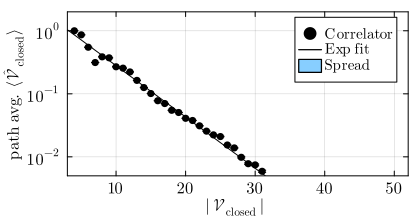

m = -0.18744860714266134 ± 0.002698633997371879


In [45]:
fntsize = 11  # Font size for all text elements

# Initialize the plot with desired axis limits, log-scale on y-axis, and visual styles
p = plot(xlim = (3,52), ylim=(0.5e-2,2), yaxis=:log,
    xformatter=:latex, yformatter=:latex,
    framestyle = :box,
    size=1.2 .* (350,180),
    legendfontsize=10,
    xtickfontsize=fntsize,
    ytickfontsize=fntsize,
    xguidefontsize=fntsize,
    yguidefontsize=fntsize)

# Add error bars to each point in the correlator (standard error), black markers
p = scatter!(mean_dist_den, mean_den,
    yerr=mean_dev_den,
    mc=:black,
    label=L"\textrm{Correlator}")

# Set custom y-ticks for log-scale
plot!(yticks = [1e-4, 1e-3, 1e-2, 1e-1, 1e0])

# Trim the data for fitting: keep points where distance is in [0, 35]
sd, sc = distance_trim(mean_dist_den, log.(mean_den), 0, 35)
sd = convert(Array{Float64,1}, sd)
sc = convert(Array{Float64,1}, sc)

# Fit a line in log scale: log(correlator) ~ distance
data = DataFrame(x = sd, y = sc)
lm2 = lm(@formula(y ~ x), data)

# Extract slope and intercept with uncertainty
c2, m2 = GLM.coeftable(lm2).cols[1]
m2_err = GLM.coeftable(lm2).cols[2][2]
println("m = $m2 ± $m2_err")

# Plot the exponential fit on top of the data
distance = 0:60
plot!(distance, exp.(m2 .* distance .+ c2), lc = :black, label=L"\textrm{Exp~fit}")

# Add a dummy shape for legend entry for "spread"
plot!(Shape([(-1,-1),(-2,-1),(-2,-2),(-1,-2)]),
    fillcolor = plot_color(:skyblue1, 1.0),
    label="\$\\textrm{Spread}\$")

# Axis labels
plot!(xlabel= L"$ |\mathcal{V_{\textrm{closed}}}\;|$",
      ylabel=L"\textrm{path~avg.~}\langle \hat{\mathcal{V}}_{\textrm{closed}} \rangle")

# Store plot in variable and display it
p_mfm_num = p
display(p)

### 8.3 Product of open Wilson lines 

In [50]:
# Compute the mean of each grouped numerator product and take absolute value (in case of negative signs)
master_mean_num_prod = abs.(mean.(master_corr_num_prod))

println("not CALCULATING THE SQRT OF THE NUMERATOR PRODUCT") 
# This log reminds you that you're using the product directly, not its square root.

# Compute standard error of the mean for each group
master_std_err_num_prod = [ std(m)/sqrt(length(m)-1) for (i,m) in enumerate(master_corr_num_prod) ]
# Alternative commented options:
# master_std_err_num_prod = [ std(m)/sqrt(length(m)-1) for m in master_corr_num_prod ]  # same as above
# master_std_err_den = [ std(m) for m in master_corr_den ]  # not relevant here, for denominator

fraction = 1.0  # Use the full data for estimating confidence envelopes

# Bin and average numerator product values by distance, with upper/lower envelopes
mean_dist_num_prod, mean_num_prod, temp, env_up, env_dn, log_dev, bins =
    distance_average_int_env_vfm(master_dist_den, master_mean_num_prod, fraction, true)

# Bin and average the standard errors, for plotting error bars
mean_dist_num_prod2, mean_dev_num_prod, temp, temp, temp, temp =
    distance_average_int_env_vfm(master_dist_den, master_std_err_num_prod, fraction, false)

# Prepend a zero to match the length or to regularize the first point (maybe for plotting)
pushfirst!(mean_dev_num_prod, 0)

# Print out the number of binned points in the mean and standard error arrays
println(length(mean_num_prod), "\t", length(mean_dev_num_prod))

# Store bins used for this plot for saving later
bins1 = bins
;

not CALCULATING THE SQRT OF THE NUMERATOR PRODUCT
47	48


In [ ]:
# flname = "./data/plot_data/correct-mc-bins-vfm-num-prod-$region-std-no-sqrt.jld"
# @save flname region spin_origin master_mean_num_prod master_std_err_num_prod mean_dist_num_prod mean_num_prod env_up env_dn fraction mean_dist_num_prod2 mean_dev_num_prod log_dev bins

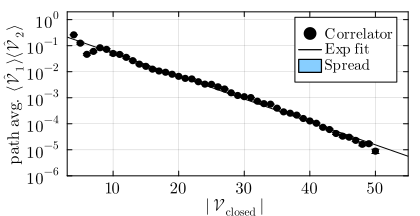

m = -0.20268108630900344 ± 0.002687838606773498


In [55]:
fntsize = 11
p = plot(xlim = (3, 55), ylim = (1e-6, 2),
         yaxis = :log,
         xformatter = :latex, yformatter = :latex,
         framestyle = :box,
         size = 1.2 .* (350, 180),
         legendfontsize = 10,
         xtickfontsize = fntsize, ytickfontsize = fntsize,
         xguidefontsize = fntsize, yguidefontsize = fntsize)

# Scatter plot with error bars
p = scatter!(mean_dist_num_prod, mean_num_prod,
             yerr = mean_dev_num_prod,
             mc = :black,
             label = L"\textrm{Correlator}")

# Set log-scale y-axis ticks
plot!(yticks = [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1e0])

# Fit log of correlator to linear model in distance range [0, 55]
sd, sc = distance_trim(mean_dist_num_prod, log.(mean_num_prod), 0, 55)
sc = convert(Vector{Float64}, sc)
sd = convert(Vector{Float64}, sd)
data = DataFrame(x = sd, y = sc)
lm2 = lm(@formula(y ~ x), data)
c2, m2 = GLM.coeftable(lm2).cols[1]
m2_err = GLM.coeftable(lm2).cols[2][2]
println("m = $m2 ± $m2_err")

# Plot the exponential fit curve
distance = 0:60
plot!(distance, exp.(m2 .* distance .+ c2),
      lc = :black,
      label = L"\textrm{Exp~fit}")

# Add dummy shape to show ribbon spread in legend
plot!(Shape([(-1,-1), (-2,-1), (-2,-2), (-1,-2)]),
      fillcolor = plot_color(:skyblue1, 1.0),
      label = L"\textrm{Spread}")

# Axis labels
plot!(xlabel = L"$ |\mathcal{V_{\textrm{closed}}}\;|$",
      ylabel = L"\textrm{path~avg.~}\langle \hat{\mathcal{V}}_{1} \rangle \langle \hat{\mathcal{V}}_{2}\rangle")

# Display plot and save if needed
p_mfm_num = p
display(p)
# savefig("./images/paper/vfm-num-prod-fit.pdf")  # Uncomment to save